# Drug Repurposing

Run `disease_split_review.ipynb` first.

In [1]:
import logging
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from matplotlib import gridspec
from openpyxl.formatting.rule import ColorScaleRule, FormulaRule
from openpyxl.styles import Alignment, Font, PatternFill
from openpyxl.utils import get_column_letter
from tqdm import tqdm

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"

_logger = logging.getLogger(__name__)

Read CSVs of nodes and edges.

In [2]:
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, dtype={"edge_index": int, "x_index": int, "y_index": int}, low_memory=False
)

_logger.info(f"Number of nodes: {len(nodes)}")
_logger.info(f"Number of edges: {len(edges) / 2:.0f}")

[12/22/25 20:58:17] INFO     Number of nodes: 147020                                                ]8;id=305835;file:///tmp/ipykernel_1718708/2575215186.py\2575215186.py]8;;\:]8;id=232633;file:///tmp/ipykernel_1718708/2575215186.py#6\6]8;;\

                    INFO     Number of edges: 7366745                                               ]8;id=637475;file:///tmp/ipykernel_1718708/2575215186.py\2575215186.py]8;;\:]8;id=835550;file:///tmp/ipykernel_1718708/2575215186.py#7\7]8;;\

## Load KG and Model

Load knowledge graph.

In [3]:
pl.seed_everything(conf.seed, workers=True)
kg = load_graph(nodes, edges)
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

Seed set to 42


Load model embeddings.

In [4]:
embeddings = torch.load(conf.paths.checkpoint.embeddings_path)

### Utility Methods

Utility method to rank prediction lists.

In [5]:
def get_pred_ranks(preds):
    if isinstance(preds, torch.Tensor):
        preds = preds.cpu().numpy()
    sorted_indices = np.argsort(preds)
    return len(preds) - np.argsort(sorted_indices)

## Disease-Centric Splits

In [6]:
def strip_disease_tag(name: str) -> str:
    return name.replace(" (disease)", "")

Identify embeddings of all disease-centric models.

In [7]:
embeddings_files = list(Path(conf.paths.split_emb_dir).glob("*_embeddings.pt"))
test_sets = [int(file.stem.split("/")[-1].split("_embeddings")[0]) for file in embeddings_files]
test_sets_df = nodes[nodes["node_type"] == "disease"]
test_sets_df = test_sets_df[test_sets_df["node_index"].isin(test_sets)].reset_index(drop=True)

For each disease, make predictions using disease-centric models.

In [8]:
# Get all drug nodes
drug_nodes = nodes[nodes["node_type"] == "drug"].copy()

# Recall matrix
recall_df = pd.DataFrame()
recall_df["k"] = range(1, len(drug_nodes) + 1)

# Number of drugs
num_drugs_df = {}
num_diseases_df = {}
num_pos_drugs_df = {}

# For each disease
pbar = tqdm(test_sets_df.iterrows(), total=len(test_sets_df), desc="Making predictions")
for i, row in pbar:
    # Get disease index
    disease_index = row["node_index"]
    disease_name = row["node_name"]

    # Update progres bar description
    desc = f"Making predictions for {disease_name}"
    pbar.set_description(desc, refresh=True)

    # Get embedding file name
    embedding_file = next(file for file in embeddings_files if str(disease_index) in file.stem)
    decoder_file = str(embedding_file).replace("_embeddings", "_decoder")
    split_embeddings = torch.load(embedding_file)
    split_decoder = torch.tensor(torch.load(decoder_file))

    # Get split prediction
    # split_pred = drug_nodes.copy()
    src_ids = [disease_index] * len(drug_nodes)
    dst_ids = drug_nodes["node_index"].values
    indication_scores = pretrain_model.get_scores_from_embeddings(
        src_ids,
        dst_ids,
        ("disease", "indication", "drug"),
        embeddings=split_embeddings,
        decoder=split_decoder,
        query_kg=kg,
        use_cache=False,
    )

    # Store predictions and ranks
    indication_ranks = get_pred_ranks(indication_scores)
    drug_nodes[f"{disease_index}_scores"] = indication_scores.cpu().numpy()
    drug_nodes[f"{disease_index}_ranks"] = indication_ranks
    drug_nodes = drug_nodes.sort_values(by=f"{disease_index}_scores").reset_index(drop=True)

    # Read in disease split
    split_file = conf.paths.splits_dir / "split_edges_GPT" / f"{disease_index}.csv"
    split_edges = pd.read_csv(split_file)

    num_drugs_df[disease_name] = len(split_edges["y_index"].unique())
    num_diseases_df[disease_name] = len(split_edges["x_index"].unique())

    # Drop contraindications and weak clinical evidence edges
    split_edges = split_edges[split_edges["relation"] != "contraindication"]
    split_edges = split_edges[split_edges["relation"] != "weak_clinical_evidence"]
    num_pos_drugs_df[disease_name] = len(split_edges["y_index"].unique())

    # If no edges, skip
    if len(split_edges) == 0:
        _logger.info(f"No edges for {disease_name}")
        continue

    # Add ground truth
    drug_nodes[f"{disease_index}_ground_truth"] = 0
    for i, row in split_edges.iterrows():
        drug_nodes.loc[drug_nodes["node_index"] == row["y_index"], f"{disease_index}_ground_truth"] = 1

    # Plot predictions as rank vs. score
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        drug_nodes[f"{disease_index}_ranks"].values,
        drug_nodes[f"{disease_index}_scores"].values,
        color="black",
        linewidth=1.5,
        zorder=2,
    )
    ax.set_xlabel("Rank", fontsize=10)
    ax.set_ylabel("Score", fontsize=10)
    ax.set_xlim(0, len(drug_nodes))

    min_score = drug_nodes[f"{disease_index}_scores"].min()
    max_score = drug_nodes[f"{disease_index}_scores"].max()
    ax.set_ylim(min_score - 0.05, max_score + 0.05)

    # Add ground truth
    ground_truth_ranks = drug_nodes[drug_nodes[f"{disease_index}_ground_truth"] == 1].copy().reset_index(drop=True)
    palette = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]

    for i, row in ground_truth_ranks.iterrows():
        node_name = row["node_name"]
        node_color = palette[i % len(palette)]
        ax.axvline(x=row[f"{disease_index}_ranks"], color=node_color, linestyle="--", alpha=0.5, zorder=3)
        if i > 12:
            ax.scatter(row[f"{disease_index}_ranks"], row[f"{disease_index}_scores"], color=node_color, zorder=3)
        else:
            ground_truth_label = f"{node_name} ({100 * row[f'{disease_index}_ranks'] / len(drug_nodes):.2f}%)"
            ax.scatter(
                row[f"{disease_index}_ranks"],
                row[f"{disease_index}_scores"],
                color=node_color,
                label=node_name,
                zorder=3,
            )

    # Also calculate and plot recall at k
    ax2 = ax.twinx()
    recall_to_plot = []
    for k in range(len(drug_nodes)):
        num_ground_truth = len(ground_truth_ranks[ground_truth_ranks[f"{disease_index}_ranks"] <= k])
        recall = num_ground_truth / len(ground_truth_ranks)
        recall_to_plot.append(recall)
    recall_df[disease_name] = recall_to_plot

    ax2.plot(
        range(len(drug_nodes)),
        recall_to_plot,
        color="red",
        linestyle="-",
        label="Recall at $k$",
        zorder=2,
        linewidth=2,
        alpha=0.5,
    )
    ax2.set_ylabel("Recall at $k$ (%)", fontsize=10, color="red")
    ax2.set_ylim(-0.05, 1.05)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))

    ax.grid(True, linestyle=":", alpha=0.5, zorder=0)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=6, fontsize=8)
    plt.title(f"{disease_name}", fontsize=14, fontweight="bold")

    # Save plot
    plt.tight_layout()
    disease_name_clean = disease_name.replace(" (disease)", "").replace(" ", "_").replace("'", "").replace("-", "_")
    os.makedirs(conf.paths.notebooks.drug_repurposing_dir / "neuro_disease_splits", exist_ok=True)
    plt.savefig(
        conf.paths.notebooks.drug_repurposing_dir / "neuro_disease_splits" / f"{disease_name_clean}.pdf",
        bbox_inches="tight",
    )
    plt.close()

# Convert counters to dataframe
num_drugs_df = pd.DataFrame.from_dict(num_drugs_df, orient="index")
num_drugs_df.columns = ["num_drugs"]
num_diseases_df = pd.DataFrame.from_dict(num_diseases_df, orient="index")
num_diseases_df.columns = ["num_diseases"]
num_pos_drugs_df = pd.DataFrame.from_dict(num_pos_drugs_df, orient="index")
num_pos_drugs_df.columns = ["num_drugs"]

 ... (more hidden) ...

[12/22/25 20:58:37] INFO     No edges for craniopharyngioma                                        ]8;id=234053;file:///tmp/ipykernel_1718708/2080374027.py\2080374027.py]8;;\:]8;id=146316;file:///tmp/ipykernel_1718708/2080374027.py#64\64]8;;\

 ... (more hidden) ...


Read in GPT-reviewed disease splits.

In [9]:
disease_splits = pd.read_csv(conf.paths.splits_dir / "disease_splits_GPT.csv")
disease_splits = disease_splits[disease_splits["disease_split_index"].isin(test_sets)]

Note, although we initially constructed disease-centric splits for 25 neurological diseases, several of these diseases had insufficient drug evidence for meaningful evaluation. Specifically, we excluded any disease that had fewer than five drugs supported by indication, strong clinical evidence, or off-label use evidence. After applying this criterion, 17 neurological diseases remained and constituted the final evaluation set.

In [10]:
# The k values we want to compare
k_values = [0.05, 0.1, 0.15, 0.20, 0.25]
k_values = [round(k * len(drug_nodes)) for k in k_values]
recall_subset = recall_df[recall_df["k"].isin(k_values)].set_index("k").T

# Ensure the columns appear in ascending order of k
recall_subset = recall_subset[k_values]
full_recall_subset = recall_subset.copy()

# Keep only diseases that have at least 5 drugs in (indication, strong clinical evidence, off-label use)
eval_diseases = num_pos_drugs_df[num_pos_drugs_df["num_drugs"] >= 5].index
recall_subset = recall_subset.loc[recall_subset.index.intersection(eval_diseases)]

# Sort diseases by their recall at k=25%
recall_subset = recall_subset.sort_values(by=k_values[::-1], ascending=False)

In [11]:
# Print stats
eval_diseases = [x.replace(" (disease)", "") for x in eval_diseases]
disease_splits = disease_splits[disease_splits["disease_split"].isin(eval_diseases)]
num_included = sum(disease_splits["gpt_eval"] == "Yes")
num_discarded = sum(disease_splits["gpt_eval"] == "No")
num_total = disease_splits.shape[0]
_logger.info(f"Number of diseases: {len(disease_splits['disease_split_index'].unique())}")
_logger.info(f"Number of included: {num_included}")
_logger.info(f"Number of discarded: {num_discarded}")
_logger.info(f"Number of total: {num_total}")

# Mean and SD number of diseases per split
full_num_diseases = disease_splits[disease_splits["gpt_eval"] == "Yes"]["disease_split"].value_counts()
mean_num_diseases = full_num_diseases.mean()
sd_num_diseases = full_num_diseases.std()
full_num_diseases_df = full_num_diseases.to_frame()
_logger.info(f"Mean number of diseases: {mean_num_diseases:.2f}")
_logger.info(f"SD number of diseases: {sd_num_diseases:.2f}")

[12/22/25 20:59:04] INFO     Number of diseases: 17                                                 ]8;id=91161;file:///tmp/ipykernel_1718708/3687684620.py\3687684620.py]8;;\:]8;id=619176;file:///tmp/ipykernel_1718708/3687684620.py#7\7]8;;\

                    INFO     Number of included: 506                                                ]8;id=243962;file:///tmp/ipykernel_1718708/3687684620.py\3687684620.py]8;;\:]8;id=529903;file:///tmp/ipykernel_1718708/3687684620.py#8\8]8;;\

                    INFO     Number of discarded: 72                                                ]8;id=681453;file:///tmp/ipykernel_1718708/3687684620.py\3687684620.py]8;;\:]8;id=735392;file:///tmp/ipykernel_1718708/3687684620.py#9\9]8;;\

                    INFO     Number of total: 578                                                  ]8;id=291704;file:///tmp/ipykernel_1718708/3687684620.py\3687684620.py]8;;\:]8;id=848749;file:///tmp/ipykernel_1718708/3687684620.py#10\10]8;;\

                    INFO     Mean number of diseases: 29.76                                        ]8;id=732052;file:///tmp/ipykernel_1718708/3687684620.py\3687684620.py]8;;\:]8;id=443143;file:///tmp/ipykernel_1718708/3687684620.py#17\17]8;;\

                    INFO     SD number of diseases: 33.47                                          ]8;id=352944;file:///tmp/ipykernel_1718708/3687684620.py\3687684620.py]8;;\:]8;id=107175;file:///tmp/ipykernel_1718708/3687684620.py#18\18]8;;\

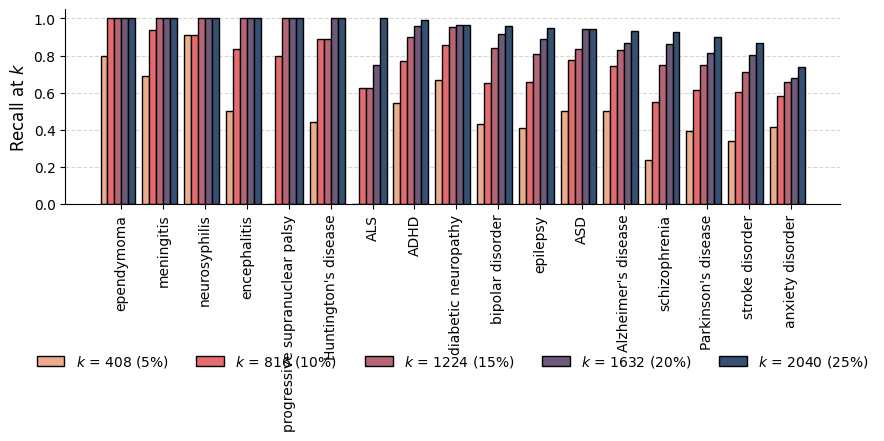

In [12]:
short_disease_names = {
    "attention deficit-hyperactivity disorder": "ADHD",
    "amyotrophic lateral sclerosis": "ALS",
    "autism spectrum disorder": "ASD",
    "X-linked dystonia-parkinsonism": "XDP",
    "Alzheimer disease": "Alzheimer's disease",
    "Parkinson disease": "Parkinson's disease",
    "Huntington disease": "Huntington's disease",
}

# X-coordinates for each disease
disease_names = recall_subset.index
diseases = []
for disease in disease_names:
    num_drugs = num_drugs_df.loc[disease, "num_drugs"]
    if disease in short_disease_names:
        disease = short_disease_names[disease]
    # diseases.append(f"{disease} ({num_drugs})")
    diseases.append(disease)
diseases = [disease.replace(" (disease)", "") for disease in diseases]
x = np.arange(len(diseases))

# Width for each bar in the group
bar_width = 1.0 / (len(k_values) + 1)
fig, ax = plt.subplots(figsize=(10, 3))

# Plot a bar for each k-value
k_colors = ["#355070", "#6d597a", "#b56576", "#e56b6f", "#eaac8b"][::-1]
for i, k in enumerate(k_values):
    frac_value = k / len(drug_nodes) * 100
    k_label = f"$k$ = {k} ({frac_value:.0f}%)"

    ax.bar(
        x + i * bar_width,
        recall_subset[k],
        width=bar_width,
        label=k_label,
        color=k_colors[i],
        edgecolor="black",
        zorder=2,
    )

ax.set_xticks(x + bar_width * (len(k_values) / 2))
ax.set_xticklabels(diseases, rotation=90, fontsize=10)

# Make legend above plot
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.85),
#           ncol=len(k_values), fontsize=10, frameon=False)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.7), ncol=len(k_values), fontsize=10, frameon=False)

# ax.set_xlabel("Disease", fontsize = 12, fontweight = 'bold')
ax.set_ylabel("Recall at ${k}$", fontsize=12)

# Make grid for y axis only
ax.grid(True, linestyle="--", alpha=0.5, zorder=0, axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# plt.tight_layout()
plt.subplots_adjust(bottom=0.23)

# Save plot
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "split_recall_at_k.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "split_recall_at_k.svg", bbox_inches="tight")

plt.show()

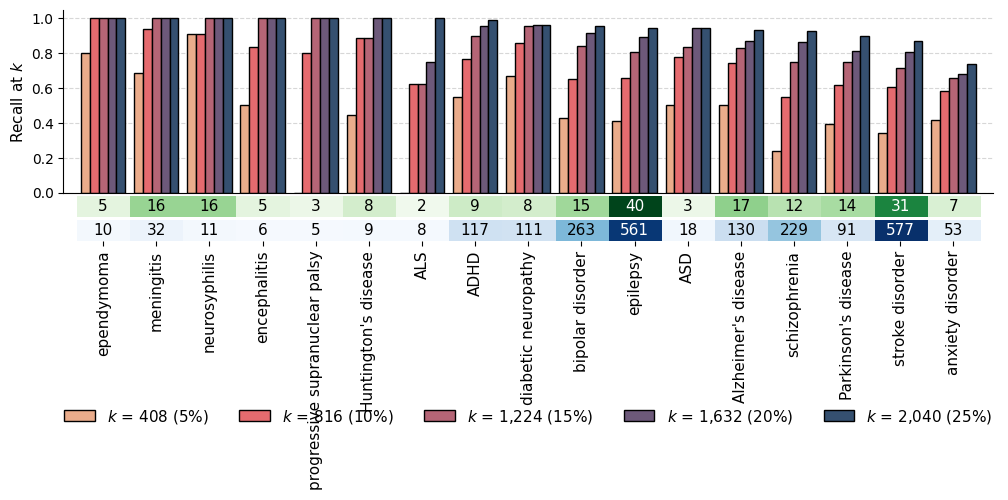

In [13]:
# Assemble data for heatmap
disease_names = recall_subset.index
n_diseases_array = num_diseases_df.loc[disease_names, "num_diseases"].values
n_drugs_array = num_pos_drugs_df.loc[disease_names, "num_drugs"].values
x = np.arange(len(disease_names))  # * spacing
bar_width = 1.0 / (len(k_values) + 1)

# Layout heatmap
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(
    nrows=3,
    ncols=1,
    height_ratios=[2.7, 0.3, 0.3],  # bars, heat-map row1, heat-map row2
    hspace=0.05,
)

ax_bar = fig.add_subplot(gs[0])
ax_hm_dis = fig.add_subplot(gs[1], sharex=ax_bar)
ax_hm_drug = fig.add_subplot(gs[2], sharex=ax_bar)
plt.setp(ax_bar.get_xticklabels(), visible=False)
plt.setp(ax_hm_dis.get_xticklabels(), visible=False)

# Bar chart
k_colors = ["#355070", "#6d597a", "#b56576", "#e56b6f", "#eaac8b"][::-1]
group_width = len(k_values) * bar_width  # total width of one bundle
half_width = group_width / 2

for i, k in enumerate(k_values):
    frac_value = k / len(drug_nodes) * 100
    label = rf"$k$ = {k:,} ({frac_value:.0f}%)"

    ax_bar.bar(
        x - half_width + i * bar_width + bar_width / 2,
        recall_subset[k],
        width=bar_width,
        label=label,
        color=k_colors[i],
        edgecolor="black",
        zorder=2,
    )

ax_bar.set_ylabel("Recall at $k$", fontsize=11)
ax_bar.legend(loc="upper center", bbox_to_anchor=(0.5, -1.1), ncol=len(k_values), fontsize=11, frameon=False)
ax_bar.grid(True, axis="y", linestyle="--", alpha=0.5, zorder=0)
ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)

# Disable major and minor ticks
ax_bar.tick_params(axis="x", which="both", bottom=False, top=False)

# Heatmap for number of diseases
cmap_dis = mpl.cm.Greens
norm_dis = mpl.colors.Normalize(vmin=0, vmax=n_diseases_array.max())

im_dis = ax_hm_dis.imshow(
    n_diseases_array.reshape(1, -1), aspect="auto", cmap=cmap_dis, norm=norm_dis, interpolation="nearest"
)

ax_hm_dis.set_yticks([])
ax_hm_dis.tick_params(axis="x", length=0)  # suppress tiny ticks
for spine in ax_hm_dis.spines.values():
    spine.set_visible(False)

# Annotate with adaptive text colour
for j, val in enumerate(n_diseases_array):
    text_col = "white" if norm_dis(val) >= 0.5 else "black"
    ax_hm_dis.text(j, 0, val, ha="center", va="center", fontsize=11, color=text_col)

# Heatmap for number of drugs
cmap_drug = mpl.cm.Blues
norm_drug = mpl.colors.Normalize(vmin=0, vmax=n_drugs_array.max())

im_drug = ax_hm_drug.imshow(
    n_drugs_array.reshape(1, -1), aspect="auto", cmap=cmap_drug, norm=norm_drug, interpolation="nearest"
)

ax_hm_drug.set_yticks([])

# X-tick positions and labels (group centres)
# group_centres = x + bar_width * (len(k_values) / 2)
pretty_names = [short_disease_names.get(name, name).replace(" (disease)", "") for name in disease_names]
# ax_hm_drug.set_xticks(group_centres)
ax_hm_drug.set_xticks(x)
ax_hm_drug.set_xticklabels(pretty_names, rotation=90, fontsize=11)

for spine in ax_hm_drug.spines.values():
    spine.set_visible(False)

for j, val in enumerate(n_drugs_array):
    text_col = "white" if norm_drug(val) >= 0.5 else "black"
    ax_hm_drug.text(j, 0, val, ha="center", va="center", fontsize=11, color=text_col)

# Ensure both axes cover exactly the same horizontal range
ax_bar.set_xlim(x[0] - 0.75, x[-1] + 0.75)

# plt.tight_layout()
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "split_recall_at_k_with_heatmap.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "split_recall_at_k_with_heatmap.svg", bbox_inches="tight")
plt.show()

Compute statistics.

In [14]:
# Compute mean and SD of recall at k values of interest
mean_recall_at_k = full_recall_subset.mean(axis=0)
sd_recall_at_k = full_recall_subset.std(axis=0)
k_pers = [k / len(drug_nodes) * 100 for k in k_values]
recall_at_k_df = pd.DataFrame({"per": k_pers, "mean": mean_recall_at_k, "sd": sd_recall_at_k})
recall_at_k_df

per      mean        sd
k                             
408    5.0  0.470021  0.325071
816   10.0  0.762609  0.232102
1224  15.0  0.898030  0.124625
1632  20.0  0.935572  0.093127
2040  25.0  0.965336  0.061498

## Bipolar Disorder Split

In [15]:
HIGHLIGHT_DISEASE = "bipolar disorder"

h_index = nodes[nodes["node_name"] == HIGHLIGHT_DISEASE]["node_index"].values[0]
h_drug_preds = drug_nodes[
    ["node_index", "node_id", "node_name", f"{h_index}_scores", f"{h_index}_ranks", f"{h_index}_ground_truth"]
].copy()

# Add rank percentage column
h_drug_preds["rank_pct"] = h_drug_preds[f"{h_index}_ranks"] / len(h_drug_preds) * 100

# Add nodes only indicated for target disease(and not rest of split)
h_indications = edges[(edges["relation"] == "indication") & (edges["x_index"] == h_index)]["y_index"].unique()
h_off_label_use = edges[(edges["relation"] == "off_label_use") & (edges["x_index"] == h_index)]["y_index"].unique()
h_strong_clin_ev = edges[(edges["relation"] == "strong_clin_ev") & (edges["x_index"] == h_index)]["y_index"].unique()

# Rename columns
h_drug_preds = h_drug_preds.rename(
    {f"{h_index}_ranks": "rank", f"{h_index}_scores": "score", f"{h_index}_ground_truth": "ground_truth"}, axis=1
)

# For each drug, check if it is indicated
h_drug_preds["indications"] = h_drug_preds["node_index"].isin(h_indications)
h_drug_preds["off_label_use"] = h_drug_preds["node_index"].isin(h_off_label_use)
h_drug_preds["strong_clin_ev"] = h_drug_preds["node_index"].isin(h_strong_clin_ev)
h_drug_preds = h_drug_preds.sort_values(by="score", ascending=False)

In [16]:
def compute_recall_at_k(df, label_col, k):
    top_k = df.head(k)
    true_positives = top_k[label_col].sum()
    total_positives = df[label_col].sum()
    recall = true_positives / total_positives if total_positives > 0 else 0
    return recall


# Choose your cutoffs
h_k_values = [0.05, 0.1, 0.15, 0.20, 0.25]
h_k_values = [round(k * len(h_drug_preds)) for k in h_k_values]

# Compute recall@k for indications and off-label use
recall_at_k_results = []

for k in h_k_values:
    recall_indications = compute_recall_at_k(h_drug_preds, "indications", k)
    recall_off_label = compute_recall_at_k(h_drug_preds, "off_label_use", k)
    recall_strong_clin_ev = compute_recall_at_k(h_drug_preds, "strong_clin_ev", k)
    recall_at_k_results.append({
        "k": k,
        "recall@k_indications": recall_indications,
        "recall@k_off_label_use": recall_off_label,
        "recall@k_strong_clin_ev": recall_strong_clin_ev,
    })

recall_at_k_df = pd.DataFrame(recall_at_k_results)
_logger.info(recall_at_k_df)

[12/22/25 20:59:07] INFO           k  recall@k_indications  recall@k_off_label_use                 ]8;id=633052;file:///tmp/ipykernel_1718708/3793527054.py\3793527054.py]8;;\:]8;id=277370;file:///tmp/ipykernel_1718708/3793527054.py#28\28]8;;\
                             recall@k_strong_clin_ev                                                               
                             0   408               0.68750                0.842105                                 
                             0                                                                                     
                             1   816               0.81250                0.947368                                 
                             0                                                                                     
                             2  1224               0.84375                0.947368                                 
                             0                                                                                     
                             3  1632               0.93750                0.947368                                 
                             0                                                                                     
                             4  2040               0.96875                1.000000                                 
                             0                                                                                     

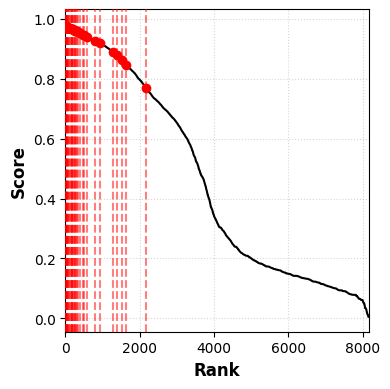

In [17]:
# Create the plot
plt.figure(figsize=(4, 4))
plt.plot(h_drug_preds["rank"].values, h_drug_preds["score"].values, color="black", linewidth=1.5, zorder=2)

# Set labels and limits
plt.xlabel("Rank", fontsize=12, fontweight="bold")
plt.ylabel("Score", fontsize=12, fontweight="bold")
plt.xlim(0, len(h_drug_preds))
min_score = h_drug_preds["score"].min()
max_score = h_drug_preds["score"].max()
plt.ylim(min_score - 0.05, max_score + 0.05)

# Define color palette
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Add ground truth
ground_truth = h_drug_preds[(h_drug_preds["indications"] == 1)].copy().reset_index(drop=True)
z_value = ground_truth.shape[0] + 10
for i, row in ground_truth.iterrows():
    node_name = row["node_name"]
    # # node_color = palette[i % len(palette)] if i < len(palette) else "gray"
    # node_color = palette[i % len(palette)]
    node_label = f"#{row['rank']}: {node_name} (top {row['rank_pct']:.2f}%)"
    node_color = "red"
    plt.axvline(x=row["rank"], color=node_color, linestyle="--", alpha=0.5, zorder=z_value)
    plt.scatter(row["rank"], row["score"], color=node_color, label=node_label, zorder=z_value)
    z_value = z_value - 1

# Add grid and legend
plt.grid(True, linestyle=":", alpha=0.5, zorder=0)
handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.22), ncol=4, fontsize=8)
# plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "BD_split_performance.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "BD_split_performance.svg", bbox_inches="tight")
plt.show()
# plt.close()

## Final Predictions

Make final predictions using the model trained on the full KG.

In [18]:
# Get drug nodes and degree lists
drug_nodes = nodes[nodes["node_type"] == "drug"].copy()
drug_degrees = []

# Get indication and contraindication edges
indications = edges[edges["relation"] == "indication"]
contraindications = edges[edges["relation"] == "contraindication"]

# Group by y_index, i.e., drug ID
indications_by_drug = indications.groupby("y_index")["x_index"].apply(list).reset_index()
contraindications_by_drug = contraindications.groupby("y_index")["x_index"].apply(list).reset_index()

# Print results
_logger.info(f"Number of drugs: {len(drug_nodes)}")
_logger.info(f"Number of drugs with >= 1 indication: {len(indications_by_drug)}")
_logger.info(f"Number of drugs with >= 1 contraindication: {len(contraindications_by_drug)}")

# Compute degree for each drug node
for drug in tqdm(drug_nodes["node_index"], desc="Computing drug degree", total=len(drug_nodes)):
    # Get degree from number of edges in CSV
    drug_edges = edges[edges["x_index"] == drug]
    drug_degrees.append(len(drug_edges))

# Add degrees to drug nodes
drug_nodes["degree"] = drug_degrees

# Merge with indications and contraindications
drug_nodes = drug_nodes.merge(indications_by_drug, left_on="node_index", right_on="y_index", how="left")
drug_nodes = drug_nodes.rename(columns={"x_index": "indications"})
drug_nodes = drug_nodes.drop(columns="y_index")
drug_nodes = drug_nodes.merge(contraindications_by_drug, left_on="node_index", right_on="y_index", how="left")
drug_nodes = drug_nodes.rename(columns={"x_index": "contraindications"})
drug_nodes = drug_nodes.drop(columns="y_index")

# Replace NaN with empty lists
drug_nodes["indications"] = drug_nodes["indications"].apply(lambda x: x if isinstance(x, list) else [])
drug_nodes["contraindications"] = drug_nodes["contraindications"].apply(lambda x: x if isinstance(x, list) else [])

[12/22/25 20:59:08] INFO     Number of drugs: 8160                                                 ]8;id=967096;file:///tmp/ipykernel_1718708/3241443025.py\3241443025.py]8;;\:]8;id=396922;file:///tmp/ipykernel_1718708/3241443025.py#14\14]8;;\

                    INFO     Number of drugs with >= 1 indication: 2201                            ]8;id=648564;file:///tmp/ipykernel_1718708/3241443025.py\3241443025.py]8;;\:]8;id=928463;file:///tmp/ipykernel_1718708/3241443025.py#15\15]8;;\

                    INFO     Number of drugs with >= 1 contraindication: 1283                      ]8;id=72933;file:///tmp/ipykernel_1718708/3241443025.py\3241443025.py]8;;\:]8;id=48050;file:///tmp/ipykernel_1718708/3241443025.py#16\16]8;;\

 ... (more hidden) ...


Create data frame of disease nodes.

In [19]:
# Get disease nodes
disease_nodes = nodes[nodes["node_type"] == "disease"].copy()
disease_degrees = []

# Add indications and contraindications
indications_by_disease = indications.groupby("x_index")["y_index"].apply(list).reset_index()
contraindications_by_disease = contraindications.groupby("x_index")["y_index"].apply(list).reset_index()

# Print results
_logger.info(f"Number of diseases: {len(disease_nodes)}")
_logger.info(f"Number of diseases with >= 1 indication: {len(indications_by_disease)}")
_logger.info(f"Number of diseases with >= 1 contraindication: {len(contraindications_by_disease)}")

# Compute degree for each drug node
for drug in tqdm(disease_nodes["node_index"], desc="Computing disease degree", total=len(disease_nodes)):
    # Get degree from number of edges in CSV
    disease_edges = edges[edges["x_index"] == drug]
    disease_degrees.append(len(disease_edges))

# Add degrees to disease nodes
disease_nodes["degree"] = disease_degrees

# Merge with indications and contraindications
disease_nodes = disease_nodes.merge(indications_by_disease, left_on="node_index", right_on="x_index", how="left")
disease_nodes = disease_nodes.rename(columns={"y_index": "indications"})
disease_nodes = disease_nodes.drop(columns="x_index")
disease_nodes = disease_nodes.merge(contraindications_by_disease, left_on="node_index", right_on="x_index", how="left")
disease_nodes = disease_nodes.rename(columns={"y_index": "contraindications"})
disease_nodes = disease_nodes.drop(columns="x_index")

# Replace NaN with empty list
disease_nodes["indications"] = disease_nodes["indications"].apply(lambda x: x if isinstance(x, list) else [])
disease_nodes["contraindications"] = disease_nodes["contraindications"].apply(
    lambda x: x if isinstance(x, list) else []
)

[12/22/25 21:01:14] INFO     Number of diseases: 22201                                             ]8;id=244098;file:///tmp/ipykernel_1718708/3305556592.py\3305556592.py]8;;\:]8;id=908573;file:///tmp/ipykernel_1718708/3305556592.py#10\10]8;;\

                    INFO     Number of diseases with >= 1 indication: 1969                         ]8;id=874628;file:///tmp/ipykernel_1718708/3305556592.py\3305556592.py]8;;\:]8;id=382554;file:///tmp/ipykernel_1718708/3305556592.py#11\11]8;;\

                    INFO     Number of diseases with >= 1 contraindication: 1280                   ]8;id=279946;file:///tmp/ipykernel_1718708/3305556592.py\3305556592.py]8;;\:]8;id=735911;file:///tmp/ipykernel_1718708/3305556592.py#12\12]8;;\

 ... (more hidden) ...


Add combined disease splits.

In [20]:
# Read disease splits
disease_splits = pd.read_csv(conf.paths.splits_dir / "disease_splits_GPT.csv")
disease_splits = disease_splits[disease_splits["gpt_eval"] == "Yes"]
split_indications = {}
split_contraindications = {}

# Iterate over splits
split_groups = disease_splits.groupby("disease_split_index")

for split_index, split_group in split_groups:
    # Merge indications and contraindications for diseases in split
    split_diseases = split_group["node_index"].values
    assert split_index in split_diseases

    indications_list = disease_nodes[disease_nodes["node_index"].isin(split_diseases)]["indications"].values
    indications_list = list({item for sublist in indications_list for item in sublist})

    contraindications_list = disease_nodes[disease_nodes["node_index"].isin(split_diseases)]["contraindications"].values
    contraindications_list = list({item for sublist in contraindications_list for item in sublist})

    # Store in dictionary
    split_indications[split_index] = indications_list
    split_contraindications[split_index] = contraindications_list

# Add indications and contraindications to disease nodes
disease_nodes["split_indications"] = disease_nodes["node_index"].map(split_indications)
disease_nodes["split_contraindications"] = disease_nodes["node_index"].map(split_contraindications)

# Replace NaN with empty list
disease_nodes["split_indications"] = disease_nodes["split_indications"].apply(
    lambda x: x if isinstance(x, list) else []
)
disease_nodes["split_contraindications"] = disease_nodes["split_contraindications"].apply(
    lambda x: x if isinstance(x, list) else []
)

Add disease subset information.

In [21]:
# Add column indicating subset
disease_nodes["subset"] = None
disease_nodes.loc[disease_nodes["node_index"].isin(test_sets), "subset"] = "neuro_disease_splits"

### Predictions

Make predictions for neurological disorders.

In [22]:
preds = {
    "drugs": drug_nodes.copy(),  # .reset_index(drop=True)
    "diseases": disease_nodes.copy(),  # .reset_index(drop=True)
    "scores": {},
    "ranks": {},
}

disease_iters = disease_nodes[~disease_nodes["subset"].isna()]
pbar_length = len(disease_iters)
disease_iters = zip(disease_iters["node_name"], disease_iters["node_index"], strict=False)

pbar = tqdm(disease_iters, desc="Computing predictions for diseases", total=pbar_length, leave=True)
for disease_name, disease_index in pbar:
    # Print disease name
    # _logger.info(f"Selected disease: {disease_name}")
    pbar.set_description(f"Predicting for {disease_name}", refresh=True)
    disease_scores = preds["drugs"][["node_index"]].copy().reset_index(drop=True)
    disease_ranks = preds["drugs"][["node_index"]].copy().reset_index(drop=True)

    # Get indication predictions
    src_ids = [disease_index] * len(drug_nodes)
    dst_ids = drug_nodes["node_index"].values
    indication_scores = pretrain_model.get_scores_from_embeddings(
        src_ids, dst_ids, ("disease", "indication", "drug"), embeddings=embeddings, query_kg=kg, use_cache=False
    )

    # Store predictions and ranks
    indication_ranks = get_pred_ranks(indication_scores)
    disease_scores["indication"] = indication_scores.cpu().numpy()
    disease_ranks["indication"] = indication_ranks

    # Add to predictions object
    preds["scores"][disease_index] = disease_scores
    preds["ranks"][disease_index] = disease_ranks

 ... (more hidden) ...


### Prediction Correlation Heatmap

Assess whether predictions are consistent across clinically related diseases.

In [23]:
score_df = preds["drugs"].copy()
rank_df = preds["drugs"].copy()
for key, value in preds["scores"].items():
    score_df[key] = value["indication"]
for key, value in preds["ranks"].items():
    rank_df[key] = value["indication"]

In [24]:
high_ranked = rank_df[test_sets].T.apply(lambda x: sum(x <= 2000) >= 1)
_logger.info("Total high-ranked drugs: %s", sum(high_ranked))
rank_df = rank_df[high_ranked]

[12/22/25 21:07:37] INFO     Total high-ranked drugs: 3071                                          ]8;id=179451;file:///tmp/ipykernel_1718708/2711234544.py\2711234544.py]8;;\:]8;id=560086;file:///tmp/ipykernel_1718708/2711234544.py#2\2]8;;\

In [25]:
group_mapping = {
    "medulloblastoma": "cancer",
    "autism spectrum disorder": "neuropsychiatric",
    "Charcot-Marie-Tooth disease": "other",
    "anxiety disorder": "neuropsychiatric",
    "Down syndrome": "other",
    "Parkinson disease": "neurodegenerative",
    "stroke disorder": "neurodegenerative",
    "epilepsy": "neuropsychiatric",
    "brain astrocytoma": "cancer",
    "bipolar disorder": "neuropsychiatric",
    "neurosyphilis": "infectious",
    "Huntington disease": "neurodegenerative",
    "schizophrenia": "neuropsychiatric",
    "brain oligodendroglioma": "cancer",
    "encephalitis": "infectious",
    "X-linked dystonia-parkinsonism": "neurodegenerative",
    "craniopharyngioma": "cancer",
    "brain meningioma": "cancer",
    "ependymoma": "cancer",
    "amyotrophic lateral sclerosis": "neurodegenerative",
    "progressive supranuclear palsy": "neurodegenerative",
    "Alzheimer disease": "neurodegenerative",
    "meningitis": "infectious",
    "diabetic neuropathy": "other",
    "ADHD": "neuropsychiatric",
}

group_colors = {
    "neurodegenerative": "#ef476f",
    "neuropsychiatric": "#ffd166",
    "cancer": "#06d6a0",
    "infectious": "#118ab2",
    "other": "gray",
}

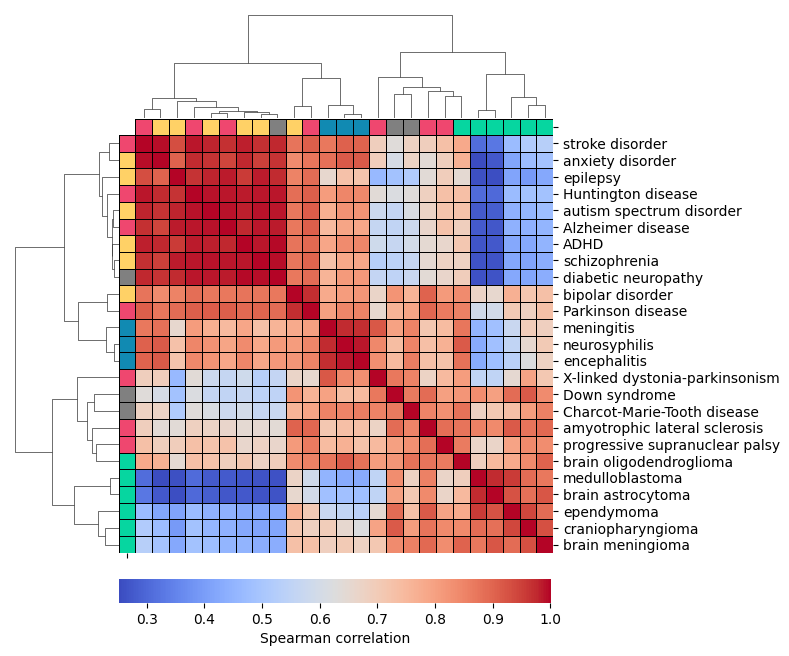

In [26]:
corr_matrix = rank_df[test_sets].corr()
disease_names = []
for disease_index in test_sets:
    disease_name = disease_nodes[disease_nodes["node_index"] == disease_index]["node_name"].values[0]
    disease_name = disease_name.replace(" (disease)", "")
    if disease_name == "attention deficit-hyperactivity disorder":
        disease_name = "ADHD"
    disease_names.append(disease_name)
corr_matrix.index = disease_names
corr_matrix.columns = disease_names

# Create group labels
group_labels = [group_mapping[disease] for disease in disease_names]
row_colors = pd.Series(group_labels, index=disease_names).map(group_colors)

# Create heatmap with hierarchical clustering
g = sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="black",
    vmax=1.001,
    cbar_kws={"label": "Spearman correlation", "orientation": "horizontal"},
    cbar_pos=(0.155, 0.24, 0.54, 0.03),  # (left, bottom, width, height)
    figsize=(8, 8),
    row_colors=row_colors,
    col_colors=row_colors,
)
# g.cax.set_orientation('horizontal')
g.ax_heatmap.tick_params(axis="x", bottom=False, top=False, labelbottom=False, labeltop=False)

# Save plot
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "top_prediction_correlation.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.drug_repurposing_dir / "top_prediction_correlation.svg", bbox_inches="tight")

plt.show()

## Evaluate Disease Predictions

In [27]:
# AD: 42049
# PD: 39579
# BD: 39528
DISEASE_ID = 39528
DISEASE_NAME = preds["diseases"][preds["diseases"]["node_index"] == DISEASE_ID]["node_name"].values[0]
CLEAN_DISEASE_NAME = DISEASE_NAME.replace(" ", "_")
DISEASE_DIR = conf.paths.notebooks.drug_repurposing_dir / "disease_predictions" / CLEAN_DISEASE_NAME
_logger.info(f"Disease: {DISEASE_NAME}\nID: {DISEASE_ID}")

# If disease directory does not exist, create it
if not os.path.exists(DISEASE_DIR):
    os.makedirs(DISEASE_DIR)

disease_preds = pd.merge(preds["drugs"], preds["scores"][DISEASE_ID], on="node_index", how="left", sort=False)
disease_preds.sort_values("indication", ascending=False, inplace=True)

# Add rank column
disease_preds["indication_rank"] = get_pred_ranks(disease_preds["indication"])
disease_preds["indication_rank_pct"] = 100 * disease_preds["indication_rank"] / len(disease_preds)

# Get BD predictions for which BD is an indication
disease_indications = disease_nodes[disease_nodes["node_index"] == DISEASE_ID]["indications"].values[0]
disease_indications = [nodes[nodes["node_index"] == ind]["node_name"].values[0] for ind in disease_indications]
disease_indications = disease_preds[disease_preds["node_name"].isin(disease_indications)]

[12/22/25 21:07:38] INFO     Disease: bipolar disorder                                              ]8;id=970342;file:///tmp/ipykernel_1718708/1399209822.py\1399209822.py]8;;\:]8;id=671088;file:///tmp/ipykernel_1718708/1399209822.py#8\8]8;;\
                             ID: 39528                                                                             

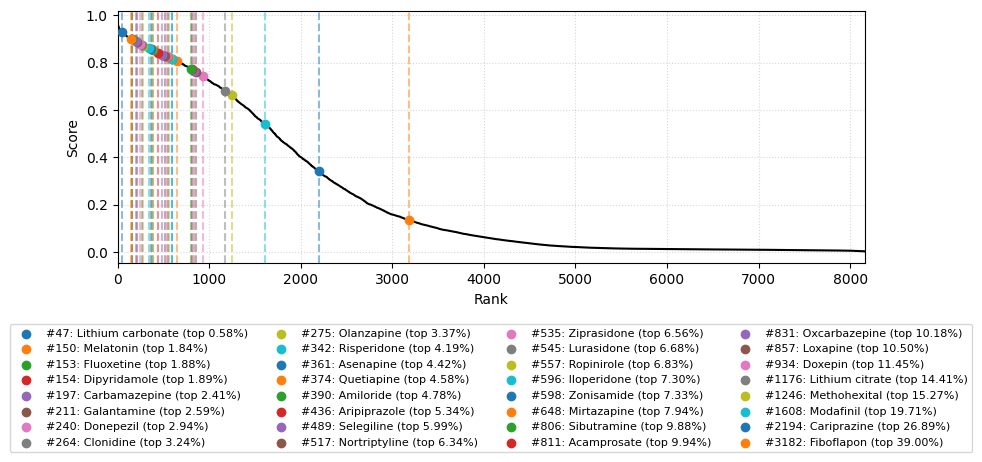

In [28]:
# Create the plot
plt.figure(figsize=(9.8, 5))
plt.plot(
    disease_preds["indication_rank"].values, disease_preds["indication"].values, color="black", linewidth=1.5, zorder=2
)

# Set labels and limits
plt.xlabel("Rank", fontsize=10)
plt.ylabel("Score", fontsize=10)
plt.xlim(0, len(disease_preds))
min_score = disease_preds["indication"].min()
max_score = disease_preds["indication"].max()
plt.ylim(min_score - 0.05, max_score + 0.05)

# Define color palette
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Add ground truth
ground_truth = disease_indications.copy().reset_index(drop=True)
z_value = ground_truth.shape[0] + 10
for i, row in ground_truth.iterrows():
    node_name = row["node_name"]
    node_color = palette[i % len(palette)]
    node_label = f"#{row['indication_rank']}: {node_name} (top {row['indication_rank_pct']:.2f}%)"
    plt.axvline(x=row["indication_rank"], color=node_color, linestyle="--", alpha=0.5, zorder=z_value)
    plt.scatter(row["indication_rank"], row["indication"], color=node_color, label=node_label, zorder=z_value)
    z_value = z_value - 1

# Add grid and legend
plt.grid(True, linestyle=":", alpha=0.5, zorder=0)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=4, fontsize=8)
plt.tight_layout()

# Show the plot
plt.savefig(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_disease_splits_performance.pdf", bbox_inches="tight")
plt.show()

## LLM Evaluation

In [29]:
# Using LangChain for easy model switching
# Set GOOGLE_API_KEY in your .env file
llm = ChatGoogleGenerativeAI(
    model=conf.llm.model_name,
    api_key=conf.GOOGLE_API_KEY,
    temperature=conf.llm.temperature,
    max_tokens=conf.llm.max_tokens,
    max_retries=2,
)

In [30]:
# Get top predictions
top_disease_preds = disease_preds.head(250).copy().reset_index(drop=True)
MODEL_NAME = conf.llm.model_name.replace("/", "-")  # Safe filename

# If responses already exist, load them
if os.path.exists(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_responses.csv"):
    _logger.info(f"Loading existing {MODEL_NAME} responses for {DISEASE_NAME}")
    responses_df = pd.read_csv(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_responses.csv")
else:
    SYSTEM_PROMPT = "You are a knowledgeable and helpful biomedical expert with deep expertise in neurological diseases, including their molecular mechanisms, clinical phenotypes, and genetic foundations. You specialize in drug repurposing, providing clear, evidence-based insights into therapeutic targets, mechanisms of action, biomarker development, and the identification of existing compounds with potential efficacy across neurological and neuropsychiatric conditions. I know you are not a medical professional, do not warn me about this."

    prompt_templates = {
        "likelihood": "How likely is it that {drug_name} would be effective in treating {disease_name}, based on current biomedical knowledge? Rate from 1 (very unlikely) to 5 (very likely). Answer with a single number from 1 to 5.",
        "novelty": "How novel is the idea of using {drug_name} to treat {disease_name}? Rate from 1 (already well-established) to 5 (completely novel, with no prior reports). Answer with a single number from 1 to 5.",
        "contraindication": "Is {drug_name} contraindicated for patients with {disease_name}? Rate from 1 (definitely contraindicated) to 5 (definitely not contraindicated). Answer with a single number from 1 to 5.",
        "mechanism": "How strong is the mechanistic rationale for using {drug_name} to treat {disease_name}? Rate from 1 (no known mechanism) to 5 (clear and well-supported mechanism). Answer with a single number from 1 to 5.",
        "category": "What category of drug is {drug_name}? Answer with a single word or phrase.",
        "primary_indication": "What is the primary indication for {drug_name}? Answer with a single word or phrase.",
    }
    
    prompt_types = ["likelihood", "novelty", "contraindication", "mechanism", "category", "primary_indication"]

    # Prepare all messages upfront
    all_messages = []
    message_index = []  # Track (drug_idx, prompt_type) for each message

    _logger.info(f"Preparing {len(top_disease_preds)} drugs × {len(prompt_types)} prompts = {len(top_disease_preds) * len(prompt_types)} messages...")
    
    for i, row in top_disease_preds.iterrows():
        drug_name = row["node_name"]
        for prompt_type in prompt_types:
            prompt_text = prompt_templates[prompt_type].format(drug_name=drug_name, disease_name=DISEASE_NAME)
            messages = [
                SystemMessage(content=SYSTEM_PROMPT),
                HumanMessage(content=prompt_text),
            ]
            all_messages.append(messages)
            message_index.append((i, prompt_type))

    # Batch inference with concurrency (adjust based on your rate limits)
    # Paid Tier 1: 2,000 RPM, so max_concurrency=10-15 is safe
    _logger.info(f"Running batch inference on {len(all_messages)} prompts with max_concurrency=10...")
    responses = llm.batch(all_messages, config={"max_concurrency": 10})
    _logger.info("Batch inference complete!")

    # Reconstruct results into per-drug dictionaries
    results = {i: {} for i in range(len(top_disease_preds))}
    for (drug_idx, prompt_type), response in zip(message_index, responses):
        response_text = response.text if hasattr(response, 'text') else response.content
        results[drug_idx][prompt_type] = response_text.strip()

    # Convert to DataFrame
    responses_df = pd.DataFrame([results[i] for i in range(len(top_disease_preds))])

    # Save to CSV
    responses_df.to_csv(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_responses.csv", index=False)
    _logger.info(f"Saved responses to {DISEASE_DIR / f'{CLEAN_DISEASE_NAME}_{MODEL_NAME}_responses.csv'}")

[12/22/25 21:07:39] INFO     Preparing 250 drugs × 6 prompts = 1500 messages...                    ]8;id=805635;file:///tmp/ipykernel_1718708/2767163056.py\2767163056.py]8;;\:]8;id=813694;file:///tmp/ipykernel_1718708/2767163056.py#27\27]8;;\

                    INFO     Running batch inference on 1500 prompts with max_concurrency=10...    ]8;id=330776;file:///tmp/ipykernel_1718708/2767163056.py\2767163056.py]8;;\:]8;id=420651;file:///tmp/ipykernel_1718708/2767163056.py#42\42]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=918938;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=752787;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=414850;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=927657;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=277746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=146413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=275504;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=783300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=418801;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=379580;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=95325;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=792495;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=657924;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=167753;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=66613;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=403457;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=263626;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=580099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=755731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=120116;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:07:45] INFO     HTTP Request: POST                                                     ]8;id=672097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=356699;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=475763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=3402;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:07:50] INFO     HTTP Request: POST                                                     ]8;id=524902;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=798975;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=912804;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=655674;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=638551;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=208573;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=565579;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=999816;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:07:52] INFO     HTTP Request: POST                                                     ]8;id=599;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=628038;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=974230;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=380612;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=251083;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=60738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=82582;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=89814;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=797549;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=558582;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=498369;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=992842;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:07:53] INFO     HTTP Request: POST                                                     ]8;id=914812;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=636059;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=791952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=765388;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:07:54] INFO     HTTP Request: POST                                                     ]8;id=418373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=704314;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=542717;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=473417;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:07:56] INFO     HTTP Request: POST                                                     ]8;id=354508;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=22056;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=230914;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=7540;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=240062;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=70674;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:07:57] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=74299;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=539131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:07:58] INFO     HTTP Request: POST                                                     ]8;id=224643;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=565427;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=598782;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=604201;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:07:59] INFO     HTTP Request: POST                                                     ]8;id=846721;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=426833;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=451989;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=371507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:02] INFO     HTTP Request: POST                                                     ]8;id=764491;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=56802;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=63556;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=422179;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:03] INFO     HTTP Request: POST                                                     ]8;id=114576;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=260735;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=146991;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=442374;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=916964;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=968114;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=897546;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=577057;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:05] INFO     HTTP Request: POST                                                     ]8;id=876638;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=15474;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=247861;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=174389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=906651;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=420521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=2260;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=409386;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:06] INFO     HTTP Request: POST                                                     ]8;id=477110;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=299105;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=582765;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=694022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:09] INFO     HTTP Request: POST                                                     ]8;id=311120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=228275;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=63918;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=784309;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=499948;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=527276;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=59642;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=532496;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=623939;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=71262;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=125710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=987335;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:10] INFO     HTTP Request: POST                                                     ]8;id=623398;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=41672;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=612024;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=592683;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:13] INFO     HTTP Request: POST                                                     ]8;id=214181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=702258;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=415011;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=137235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:14] INFO     HTTP Request: POST                                                     ]8;id=331535;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=974146;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=480547;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=651332;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:15] INFO     HTTP Request: POST                                                     ]8;id=223508;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=530458;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=923653;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=72132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=165409;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=459469;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=641390;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=846305;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:18] INFO     HTTP Request: POST                                                     ]8;id=856795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=581542;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=984539;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=920782;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=112235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=778480;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=634210;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=220861;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:19] INFO     HTTP Request: POST                                                     ]8;id=665046;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=894343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=949314;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=952273;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:20] INFO     HTTP Request: POST                                                     ]8;id=444151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=869634;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=808577;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=137174;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:23] INFO     HTTP Request: POST                                                     ]8;id=463298;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=578478;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=117308;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=78898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:25] INFO     HTTP Request: POST                                                     ]8;id=156294;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=572092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=579364;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=155287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=382364;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=942650;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=942590;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=375190;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:27] INFO     HTTP Request: POST                                                     ]8;id=107786;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=370858;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=426117;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=650810;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=248237;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=906604;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=924231;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=432322;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=348321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=820391;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=906036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=770763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=825622;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=735343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=900300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=493554;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:31] INFO     HTTP Request: POST                                                     ]8;id=482662;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=366643;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=238651;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=233752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=344207;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=292136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=368203;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=672642;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:32] INFO     HTTP Request: POST                                                     ]8;id=562262;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=347235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=273903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=187241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=625550;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=455673;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=457592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=635656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:36] INFO     HTTP Request: POST                                                     ]8;id=604596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=199312;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=1773;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=545175;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:38] INFO     HTTP Request: POST                                                     ]8;id=754377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=985937;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=381913;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=452248;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:40] INFO     HTTP Request: POST                                                     ]8;id=346239;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=653425;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=754717;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=943767;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=428231;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=342027;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=133470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=201158;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:43] INFO     HTTP Request: POST                                                     ]8;id=710219;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=784475;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=315568;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=425800;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=300850;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=220392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=686508;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=337902;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=224082;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=536004;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=771711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=177934;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=696101;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=663686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=998243;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=787625;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:45] INFO     HTTP Request: POST                                                     ]8;id=845742;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=208802;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=498216;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=640967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=434572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=929181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=730180;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=402630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:46] INFO     HTTP Request: POST                                                     ]8;id=687926;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=721024;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=807451;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=928477;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:47] INFO     HTTP Request: POST                                                     ]8;id=184430;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=843170;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=584482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=261303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:48] INFO     HTTP Request: POST                                                     ]8;id=139816;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=840346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=624377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=332711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:51] INFO     HTTP Request: POST                                                     ]8;id=642412;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=854596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=870914;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=950906;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:54] INFO     HTTP Request: POST                                                     ]8;id=779779;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=903342;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=259249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=880660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:57] INFO     HTTP Request: POST                                                     ]8;id=546622;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=508136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=81247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=748206;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:58] INFO     HTTP Request: POST                                                     ]8;id=335239;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=936406;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=242495;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=401641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:08:59] INFO     HTTP Request: POST                                                     ]8;id=67348;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=435020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=435970;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=65290;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:00] INFO     HTTP Request: POST                                                     ]8;id=948791;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=807189;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=898348;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=923435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=6182;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=988536;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=894905;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=934953;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:02] INFO     HTTP Request: POST                                                     ]8;id=783826;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=770319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=231251;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=511945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:03] INFO     HTTP Request: POST                                                     ]8;id=30434;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=407746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=423956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=759359;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=133827;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=652483;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=620644;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=591807;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=449433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=142291;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=272793;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=397519;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:06] INFO     HTTP Request: POST                                                     ]8;id=353894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=798207;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=997409;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=872335;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:07] INFO     HTTP Request: POST                                                     ]8;id=493152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=20324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=366960;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=235113;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:08] INFO     HTTP Request: POST                                                     ]8;id=42213;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=790870;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=879995;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=21369;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:10] INFO     HTTP Request: POST                                                     ]8;id=496564;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=701978;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=487623;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=733442;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:11] INFO     HTTP Request: POST                                                     ]8;id=635324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=636745;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=859099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=171720;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=974008;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=327110;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=415922;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=987203;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:16] INFO     HTTP Request: POST                                                     ]8;id=724161;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=870917;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=810004;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=316232;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:17] INFO     HTTP Request: POST                                                     ]8;id=126935;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=834904;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=558623;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=449186;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:18] INFO     HTTP Request: POST                                                     ]8;id=678998;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=357806;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=514013;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=110665;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:19] INFO     HTTP Request: POST                                                     ]8;id=868962;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=482071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=769440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=547091;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=964289;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=564315;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=865845;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=766536;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:20] INFO     HTTP Request: POST                                                     ]8;id=257420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=871084;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=472700;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=255709;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:21] INFO     HTTP Request: POST                                                     ]8;id=700646;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=397399;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=340802;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=190672;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:23] INFO     HTTP Request: POST                                                     ]8;id=270902;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=356871;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=922859;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=289688;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:25] INFO     HTTP Request: POST                                                     ]8;id=200337;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=89771;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=582144;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=794993;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=746420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=514663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=308528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=232360;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:26] INFO     HTTP Request: POST                                                     ]8;id=696212;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=609805;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=360455;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=446173;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:29] INFO     HTTP Request: POST                                                     ]8;id=736996;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=475786;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=126516;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=756321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=561894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=997067;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=226895;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=774483;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:31] INFO     HTTP Request: POST                                                     ]8;id=797135;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=550121;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=203547;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=310636;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:32] INFO     HTTP Request: POST                                                     ]8;id=14835;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=742411;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=57174;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=580238;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:34] INFO     HTTP Request: POST                                                     ]8;id=668854;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=910647;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=12861;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=601949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:35] INFO     HTTP Request: POST                                                     ]8;id=357256;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=193319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=500935;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=119629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=77680;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=605050;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=156445;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=850544;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:37] INFO     HTTP Request: POST                                                     ]8;id=260247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=124205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=625084;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=829151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:38] INFO     HTTP Request: POST                                                     ]8;id=398855;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=472398;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=617113;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=449660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=639244;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=776039;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=655900;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=221275;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:40] INFO     HTTP Request: POST                                                     ]8;id=251516;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=182256;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=428361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=472387;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=34225;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=242720;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=901362;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=476086;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:41] INFO     HTTP Request: POST                                                     ]8;id=277405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=826097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=842956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=979022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:42] INFO     HTTP Request: POST                                                     ]8;id=235729;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=679094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=149145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=74878;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:43] INFO     HTTP Request: POST                                                     ]8;id=623948;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=785339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=460485;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=130394;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:45] INFO     HTTP Request: POST                                                     ]8;id=422060;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=988467;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=459023;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=84349;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:49] INFO     HTTP Request: POST                                                     ]8;id=770214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=337978;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=240044;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=707053;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:51] INFO     HTTP Request: POST                                                     ]8;id=996971;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=21753;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=604238;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=42185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=544173;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=683157;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=613762;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=457058;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=492841;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=364863;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=109680;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=899398;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:52] INFO     HTTP Request: POST                                                     ]8;id=519536;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=302218;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=797441;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=576818;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:53] INFO     HTTP Request: POST                                                     ]8;id=264659;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=338977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=539593;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=864998;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=484417;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=433321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=652878;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=793188;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:54] INFO     HTTP Request: POST                                                     ]8;id=54118;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=213446;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=302020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=459398;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:56] INFO     HTTP Request: POST                                                     ]8;id=30271;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=660626;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=166071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=325845;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=97736;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=235615;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=993065;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=123172;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:09:57] INFO     HTTP Request: POST                                                     ]8;id=977957;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=751413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=435673;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=875271;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:00] INFO     HTTP Request: POST                                                     ]8;id=578043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=151668;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=532929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=782544;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:02] INFO     HTTP Request: POST                                                     ]8;id=289666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=810208;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=979630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=825981;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:03] INFO     HTTP Request: POST                                                     ]8;id=296578;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=761319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=691998;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=513425;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:07] INFO     HTTP Request: POST                                                     ]8;id=507868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=361888;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=395533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=477463;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=731380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=250405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=813217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=430728;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:08] INFO     HTTP Request: POST                                                     ]8;id=739485;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=957800;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=830884;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=860616;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=132378;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=526690;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=916655;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=886088;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:09] INFO     HTTP Request: POST                                                     ]8;id=479123;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=16093;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=686587;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=161859;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=355007;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=653534;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=893140;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=344525;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:10] INFO     HTTP Request: POST                                                     ]8;id=398468;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=332043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=511650;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=914759;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:11] INFO     HTTP Request: POST                                                     ]8;id=246174;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=661820;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=783041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=94769;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:13] INFO     HTTP Request: POST                                                     ]8;id=738083;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=914965;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=314012;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=947308;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:14] INFO     HTTP Request: POST                                                     ]8;id=58845;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=307618;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=256059;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=556968;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:17] INFO     HTTP Request: POST                                                     ]8;id=188803;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=178240;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=401126;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=649813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:18] INFO     HTTP Request: POST                                                     ]8;id=611484;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=150069;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=481894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=267729;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=487853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=944986;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=77449;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=463187;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:19] INFO     HTTP Request: POST                                                     ]8;id=669975;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=444920;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=316797;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=208894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:21] INFO     HTTP Request: POST                                                     ]8;id=248728;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=399889;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=733247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=309571;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:23] INFO     HTTP Request: POST                                                     ]8;id=287813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=8491;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=780841;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=51426;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=873294;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=948075;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=241296;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=636553;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:24] INFO     HTTP Request: POST                                                     ]8;id=199367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=651051;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=804751;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=691201;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:25] INFO     HTTP Request: POST                                                     ]8;id=101883;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=947287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=826918;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=462236;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=137795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=94511;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=435686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=184171;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:26] INFO     HTTP Request: POST                                                     ]8;id=919035;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=383629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=870813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=172537;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:27] INFO     HTTP Request: POST                                                     ]8;id=505254;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=845664;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=843298;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=120764;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:31] INFO     HTTP Request: POST                                                     ]8;id=236574;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=901922;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=886827;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=843671;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:32] INFO     HTTP Request: POST                                                     ]8;id=413741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=14594;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=386490;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=705511;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=399534;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=862367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:10:33] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=707617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=245180;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=988984;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=588678;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=679112;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=66287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=735132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=316869;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=47549;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=992227;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:34] INFO     HTTP Request: POST                                                     ]8;id=101913;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=246205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=475679;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=389033;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:38] INFO     HTTP Request: POST                                                     ]8;id=991925;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=566432;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=162029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=928423;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:39] INFO     HTTP Request: POST                                                     ]8;id=513117;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=645558;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=34305;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=723811;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:40] INFO     HTTP Request: POST                                                     ]8;id=996729;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=247582;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=385178;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=570913;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=417479;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=289282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=864226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=476805;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:42] INFO     HTTP Request: POST                                                     ]8;id=670556;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=626152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=255400;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=132040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:45] INFO     HTTP Request: POST                                                     ]8;id=870127;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=802325;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=852547;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=911941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=826952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=944275;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=151716;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=136306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=115266;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=693169;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=375644;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=828358;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:47] INFO     HTTP Request: POST                                                     ]8;id=16547;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=182710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=441409;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=551640;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:48] INFO     HTTP Request: POST                                                     ]8;id=470050;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=815809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=473962;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=528313;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:49] INFO     HTTP Request: POST                                                     ]8;id=762569;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=821273;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=316282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=480292;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:54] INFO     HTTP Request: POST                                                     ]8;id=888456;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=421126;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=747006;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=953890;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=337758;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=637846;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=654644;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=663829;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:55] INFO     HTTP Request: POST                                                     ]8;id=399407;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=626410;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=634836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=451096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=894217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=686516;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=755855;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=907534;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:56] INFO     HTTP Request: POST                                                     ]8;id=239592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=433914;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=436196;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=765054;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:10:59] INFO     HTTP Request: POST                                                     ]8;id=697416;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=267271;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=967819;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=497305;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:00] INFO     HTTP Request: POST                                                     ]8;id=97758;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=452855;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=851201;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=136435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=588967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=345658;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=916043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=697660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:02] INFO     HTTP Request: POST                                                     ]8;id=960331;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=756086;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=368727;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=108633;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=688637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=505612;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=886438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=583286;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:05] INFO     HTTP Request: POST                                                     ]8;id=601987;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=237144;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=804711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=858182;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:06] INFO     HTTP Request: POST                                                     ]8;id=583783;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=27529;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=727157;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=280439;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:07] INFO     HTTP Request: POST                                                     ]8;id=799444;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=323993;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=190217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=912117;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=72965;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=148766;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=782354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=556251;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:08] INFO     HTTP Request: POST                                                     ]8;id=357455;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=165055;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=814571;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=987137;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:09] INFO     HTTP Request: POST                                                     ]8;id=55164;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=163137;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=706707;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=85544;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:10] INFO     HTTP Request: POST                                                     ]8;id=509253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=636565;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=791615;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=537234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:14] INFO     HTTP Request: POST                                                     ]8;id=297005;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=711163;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=699539;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=323401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:16] INFO     HTTP Request: POST                                                     ]8;id=57443;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=8060;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=804624;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=143901;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=125812;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=8105;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=135461;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=398676;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:17] INFO     HTTP Request: POST                                                     ]8;id=585864;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=873835;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=416359;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=903625;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:18] INFO     HTTP Request: POST                                                     ]8;id=482087;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=965908;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=450137;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=601253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:20] INFO     HTTP Request: POST                                                     ]8;id=303578;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=120768;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=840247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=993645;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:21] INFO     HTTP Request: POST                                                     ]8;id=964448;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=379430;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=255135;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=456839;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:22] INFO     HTTP Request: POST                                                     ]8;id=414991;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=912811;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=349247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=816964;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:23] INFO     HTTP Request: POST                                                     ]8;id=119565;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=556379;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=366346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=368154;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=154864;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=247745;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=181926;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=631661;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:24] INFO     HTTP Request: POST                                                     ]8;id=79013;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=185751;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=486490;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=791093;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:27] INFO     HTTP Request: POST                                                     ]8;id=714220;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=969045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=654858;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=338908;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=461124;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=71603;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=835012;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=288016;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:28] INFO     HTTP Request: POST                                                     ]8;id=77794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=325486;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=386649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=872097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:29] INFO     HTTP Request: POST                                                     ]8;id=896840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=94682;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=485188;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=608519;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:32] INFO     HTTP Request: POST                                                     ]8;id=43015;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=471579;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=197383;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=337145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=64879;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=472407;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=360120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=749014;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:34] INFO     HTTP Request: POST                                                     ]8;id=41043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=259778;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=548141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=639427;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=296635;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=406235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=626928;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=54909;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=69113;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=345705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=297949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=264236;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:35] INFO     HTTP Request: POST                                                     ]8;id=631977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=915700;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=695847;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=148298;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:36] INFO     HTTP Request: POST                                                     ]8;id=732409;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=694299;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=983566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=88834;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:39] INFO     HTTP Request: POST                                                     ]8;id=830117;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=344432;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=869226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=993115;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:40] INFO     HTTP Request: POST                                                     ]8;id=97992;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=677406;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=19116;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=380211;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:43] INFO     HTTP Request: POST                                                     ]8;id=358332;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=993702;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=144247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=162471;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:44] INFO     HTTP Request: POST                                                     ]8;id=106053;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=532351;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=926607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=552108;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:45] INFO     HTTP Request: POST                                                     ]8;id=803531;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=648052;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=170128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=189630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:48] INFO     HTTP Request: POST                                                     ]8;id=848343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=946503;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=430816;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=381995;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=640255;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=298768;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=245369;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=559951;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:49] INFO     HTTP Request: POST                                                     ]8;id=491798;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=947885;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=993137;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=598128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=815922;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=400422;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=856572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=209398;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:50] INFO     HTTP Request: POST                                                     ]8;id=262147;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=54714;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:11:51] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=581478;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=979677;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=892512;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=130734;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=286042;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=471145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:53] INFO     HTTP Request: POST                                                     ]8;id=458723;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=96168;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=473041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=927601;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:55] INFO     HTTP Request: POST                                                     ]8;id=55843;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=415712;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=85569;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=393124;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=103896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=879940;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=153143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=144283;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:57] INFO     HTTP Request: POST                                                     ]8;id=495404;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=729884;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=491897;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=470392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:58] INFO     HTTP Request: POST                                                     ]8;id=19927;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=268355;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=985898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=762560;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:11:59] INFO     HTTP Request: POST                                                     ]8;id=813875;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=302096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=250021;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=440218;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:01] INFO     HTTP Request: POST                                                     ]8;id=65858;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=116242;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=562093;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=17233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:02] INFO     HTTP Request: POST                                                     ]8;id=753448;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=150551;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=369954;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=252249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:04] INFO     HTTP Request: POST                                                     ]8;id=700674;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=89772;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=551613;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=570511;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:06] INFO     HTTP Request: POST                                                     ]8;id=21322;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=409420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=405674;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=391435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:07] INFO     HTTP Request: POST                                                     ]8;id=826823;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=70841;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=658775;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=108699;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:08] INFO     HTTP Request: POST                                                     ]8;id=348671;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=139890;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=853025;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=674020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:09] INFO     HTTP Request: POST                                                     ]8;id=487192;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=729168;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=141403;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=66165;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:11] INFO     HTTP Request: POST                                                     ]8;id=38780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=307696;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=928818;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=43941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:12] INFO     HTTP Request: POST                                                     ]8;id=417568;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=855015;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=789882;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=678324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:13] INFO     HTTP Request: POST                                                     ]8;id=818771;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=50126;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=130521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=838171;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:15] INFO     HTTP Request: POST                                                     ]8;id=779414;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=461097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=520306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=725686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:19] INFO     HTTP Request: POST                                                     ]8;id=544500;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=279676;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=82760;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=451524;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=308036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=336814;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=310000;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=321384;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=174739;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=723270;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=762120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=912300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:20] INFO     HTTP Request: POST                                                     ]8;id=287892;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=670532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=703787;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=668480;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:21] INFO     HTTP Request: POST                                                     ]8;id=786325;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=712413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=889894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=637086;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:22] INFO     HTTP Request: POST                                                     ]8;id=132361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=70499;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=379742;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=401451;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=160891;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=712048;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=465504;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=800152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:24] INFO     HTTP Request: POST                                                     ]8;id=384774;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=417368;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=118959;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=27172;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=405785;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=957918;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=272933;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=738237;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:26] INFO     HTTP Request: POST                                                     ]8;id=727691;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=960997;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=894253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=77649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:28] INFO     HTTP Request: POST                                                     ]8;id=466732;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=92055;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=700280;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=364301;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:31] INFO     HTTP Request: POST                                                     ]8;id=304466;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=934629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=744031;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=972370;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=379052;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=533469;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=145622;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=248235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=580933;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=600076;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=136074;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=641674;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:33] INFO     HTTP Request: POST                                                     ]8;id=417500;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=751759;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=806527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=429322;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:34] INFO     HTTP Request: POST                                                     ]8;id=332427;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=673540;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=542491;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=361249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=578083;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=670872;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=453633;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=527290;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:37] INFO     HTTP Request: POST                                                     ]8;id=130192;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=543269;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=338334;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=980143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:38] INFO     HTTP Request: POST                                                     ]8;id=986609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=544103;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=262778;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=205837;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:39] INFO     HTTP Request: POST                                                     ]8;id=655383;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=317534;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=672124;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=176827;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=179516;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=690731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=354019;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=883456;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:40] INFO     HTTP Request: POST                                                     ]8;id=905740;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=29751;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=808475;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=604788;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=599929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=436822;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=932180;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=657629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:43] INFO     HTTP Request: POST                                                     ]8;id=506404;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=256773;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=311882;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=475575;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:44] INFO     HTTP Request: POST                                                     ]8;id=460959;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=435810;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=636129;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=150647;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:45] INFO     HTTP Request: POST                                                     ]8;id=769864;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=902590;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=388539;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=539995;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:46] INFO     HTTP Request: POST                                                     ]8;id=489131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=128473;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=101514;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=53063;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:48] INFO     HTTP Request: POST                                                     ]8;id=645270;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=438446;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=852993;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=343341;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:49] INFO     HTTP Request: POST                                                     ]8;id=199055;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=800190;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=522987;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=921777;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:51] INFO     HTTP Request: POST                                                     ]8;id=991148;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=412344;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=611680;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=370037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=626543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=925199;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=299628;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=562761;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:55] INFO     HTTP Request: POST                                                     ]8;id=140440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=925321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=422842;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=383713;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=589107;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=204110;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=405116;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=528750;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:56] INFO     HTTP Request: POST                                                     ]8;id=865401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=653516;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=101377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=413037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=984558;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=383366;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=533853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=420884;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:57] INFO     HTTP Request: POST                                                     ]8;id=143693;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=748255;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=479187;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=156175;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:12:59] INFO     HTTP Request: POST                                                     ]8;id=343897;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=976610;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=646447;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=775232;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:02] INFO     HTTP Request: POST                                                     ]8;id=531958;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=868524;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=590268;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=314353;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=347329;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=706537;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=835457;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=942425;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:04] INFO     HTTP Request: POST                                                     ]8;id=27941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=625905;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=813864;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=606574;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=611868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=503787;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=649840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=812233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:05] INFO     HTTP Request: POST                                                     ]8;id=713793;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=253961;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=115233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=200051;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:07] INFO     HTTP Request: POST                                                     ]8;id=158787;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=433020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=812617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=641181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:09] INFO     HTTP Request: POST                                                     ]8;id=771581;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=762736;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=217413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=588132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:11] INFO     HTTP Request: POST                                                     ]8;id=395129;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=328993;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=358955;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=572808;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:13] INFO     HTTP Request: POST                                                     ]8;id=755944;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=713813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=639711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=507699;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:15] INFO     HTTP Request: POST                                                     ]8;id=312999;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=235790;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=739142;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=217346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=503110;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=365746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=756719;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=286741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=569576;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=398138;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=810616;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=843700;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:17] INFO     HTTP Request: POST                                                     ]8;id=748831;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=82868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=268900;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=783641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:18] INFO     HTTP Request: POST                                                     ]8;id=564739;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=284303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=143941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=114532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=254235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=53231;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=668933;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=244146;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:20] INFO     HTTP Request: POST                                                     ]8;id=752204;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=495351;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=5433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=577086;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=980452;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=923425;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=209144;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=792630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:21] INFO     HTTP Request: POST                                                     ]8;id=62036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=952040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=243500;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=561147;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:22] INFO     HTTP Request: POST                                                     ]8;id=39110;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=957590;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=878292;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=184327;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:23] INFO     HTTP Request: POST                                                     ]8;id=416278;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=826236;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=914663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=971023;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=312886;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=595551;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=298384;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=476419;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=932456;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=984152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=286090;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=202177;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:24] INFO     HTTP Request: POST                                                     ]8;id=766634;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=481206;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=14768;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=772399;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=707160;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=794068;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=669752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=940617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:25] INFO     HTTP Request: POST                                                     ]8;id=343856;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=90951;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=147442;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=500646;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:28] INFO     HTTP Request: POST                                                     ]8;id=273453;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=402206;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=345637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=316613;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:30] INFO     HTTP Request: POST                                                     ]8;id=274258;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=685436;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=700224;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=123967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=719400;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=526930;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=807236;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=326084;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:33] INFO     HTTP Request: POST                                                     ]8;id=986327;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=309369;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=140057;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=501410;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:36] INFO     HTTP Request: POST                                                     ]8;id=391774;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=436045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=794139;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=563628;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=798867;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=259486;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=825618;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=85847;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:39] INFO     HTTP Request: POST                                                     ]8;id=379358;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=81896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=869032;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=574251;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=562728;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=157131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=463303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=121886;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:40] INFO     HTTP Request: POST                                                     ]8;id=512573;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=95359;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=58338;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=475458;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=591303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=60541;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=323139;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=758414;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:42] INFO     HTTP Request: POST                                                     ]8;id=3161;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=782032;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=444278;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=361264;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=979981;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=937656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=301036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=428728;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:44] INFO     HTTP Request: POST                                                     ]8;id=672687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=764715;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=401058;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=470325;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=393892;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=84148;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=139449;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=685280;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=563356;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=412151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=875373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=3642;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:51] INFO     HTTP Request: POST                                                     ]8;id=706215;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=754024;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=863355;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=240820;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:52] INFO     HTTP Request: POST                                                     ]8;id=289039;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=197636;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=118326;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=33782;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:55] INFO     HTTP Request: POST                                                     ]8;id=803265;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=981716;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=216092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=70559;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:56] INFO     HTTP Request: POST                                                     ]8;id=626822;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=704667;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=776513;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=46385;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:57] INFO     HTTP Request: POST                                                     ]8;id=227823;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=791030;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=528373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=303314;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=604095;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=334394;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=858136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=336241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:13:59] INFO     HTTP Request: POST                                                     ]8;id=692282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=546571;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=63918;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=583761;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=955858;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=183640;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=519696;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=49161;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:00] INFO     HTTP Request: POST                                                     ]8;id=399669;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=823975;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=428090;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=156466;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:05] INFO     HTTP Request: POST                                                     ]8;id=564058;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=496520;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=899197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=741948;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:06] INFO     HTTP Request: POST                                                     ]8;id=60423;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=589704;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=140606;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=407286;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:09] INFO     HTTP Request: POST                                                     ]8;id=678120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=82911;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=96955;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=561654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:11] INFO     HTTP Request: POST                                                     ]8;id=281502;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=395489;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=916057;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=76319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=759489;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=704066;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:14:12] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=911709;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=951092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=222096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=982683;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=790973;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=502184;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=737954;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=214447;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=337237;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=813185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:13] INFO     HTTP Request: POST                                                     ]8;id=680233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=376710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=925695;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=521433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=492296;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=798625;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=388712;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=328122;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=232022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=777259;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=980165;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=612401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:15] INFO     HTTP Request: POST                                                     ]8;id=159814;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=205721;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=873844;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=257666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:19] INFO     HTTP Request: POST                                                     ]8;id=718113;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=353961;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=758705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=672865;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=768367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=833592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=573095;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=512036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:21] INFO     HTTP Request: POST                                                     ]8;id=672985;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=61585;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=77941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=991101;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:22] INFO     HTTP Request: POST                                                     ]8;id=6693;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=432424;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=71269;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=741521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:26] INFO     HTTP Request: POST                                                     ]8;id=478160;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=391329;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=979269;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=646467;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:27] INFO     HTTP Request: POST                                                     ]8;id=16495;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=6933;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=17538;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=555134;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=17975;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=526611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=845328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=985359;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:30] INFO     HTTP Request: POST                                                     ]8;id=100992;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=549857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=552029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=264679;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=416176;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=82857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=255021;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=731105;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:31] INFO     HTTP Request: POST                                                     ]8;id=889053;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=84532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=33223;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=98042;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:32] INFO     HTTP Request: POST                                                     ]8;id=499127;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=58840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=86702;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=524139;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=347362;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=593343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=963800;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=44618;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:35] INFO     HTTP Request: POST                                                     ]8;id=725916;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=930668;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=969051;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=77959;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:36] INFO     HTTP Request: POST                                                     ]8;id=569408;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=590882;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=891737;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=329761;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:37] INFO     HTTP Request: POST                                                     ]8;id=788795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=860556;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=80674;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=313814;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:39] INFO     HTTP Request: POST                                                     ]8;id=875194;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=890704;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=347843;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=402491;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:40] INFO     HTTP Request: POST                                                     ]8;id=722794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=759340;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=56304;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=102430;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:43] INFO     HTTP Request: POST                                                     ]8;id=357137;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=634565;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=811131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=342230;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=472436;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=514435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=393663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=452825;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=398535;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=89856;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=258421;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=747748;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:45] INFO     HTTP Request: POST                                                     ]8;id=398458;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=746247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=408548;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=332061;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:47] INFO     HTTP Request: POST                                                     ]8;id=988765;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=323241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=107197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=138943;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=584041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=581687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=93972;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=371106;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:48] INFO     HTTP Request: POST                                                     ]8;id=822543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=340189;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=433911;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=406637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:50] INFO     HTTP Request: POST                                                     ]8;id=586716;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=949178;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=718605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=399226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:51] INFO     HTTP Request: POST                                                     ]8;id=281444;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=517077;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=289366;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=441557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:52] INFO     HTTP Request: POST                                                     ]8;id=378666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=263926;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=519886;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=622651;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:53] INFO     HTTP Request: POST                                                     ]8;id=142071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=319457;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=882495;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=650318;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:14:59] INFO     HTTP Request: POST                                                     ]8;id=461607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=350996;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=682661;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=623266;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=993293;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=729066;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=417584;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=334640;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:00] INFO     HTTP Request: POST                                                     ]8;id=514858;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=603853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=293916;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=856156;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:02] INFO     HTTP Request: POST                                                     ]8;id=977343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=591240;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=714827;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=804905;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:04] INFO     HTTP Request: POST                                                     ]8;id=484045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=988780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=305482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=871662;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:05] INFO     HTTP Request: POST                                                     ]8;id=834306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=833665;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=664100;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=317543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=749979;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=443681;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=626979;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=502514;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:06] INFO     HTTP Request: POST                                                     ]8;id=968355;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=965101;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=38551;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=829130;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=562986;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=622665;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=806306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=260289;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:07] INFO     HTTP Request: POST                                                     ]8;id=678428;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=642439;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=678159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=419029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=111090;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=11060;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=783132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=543998;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:12] INFO     HTTP Request: POST                                                     ]8;id=231768;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=467432;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=712565;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=617181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:13] INFO     HTTP Request: POST                                                     ]8;id=25755;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=506222;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=90025;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=121707;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:14] INFO     HTTP Request: POST                                                     ]8;id=365249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=327040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=546428;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=506384;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:15] INFO     HTTP Request: POST                                                     ]8;id=757065;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=730609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=46853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=849541;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=359743;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=679445;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=975094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=776459;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:16] INFO     HTTP Request: POST                                                     ]8;id=167914;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=347067;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=836507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=424723;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=689237;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=453125;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=925994;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=206909;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:18] INFO     HTTP Request: POST                                                     ]8;id=4666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=738968;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=737945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=848014;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:20] INFO     HTTP Request: POST                                                     ]8;id=838338;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=914336;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=206647;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=479776;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:21] INFO     HTTP Request: POST                                                     ]8;id=513261;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=553349;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=641003;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=411612;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=886589;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=480101;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=740282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=839503;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:22] INFO     HTTP Request: POST                                                     ]8;id=88868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=704758;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=320214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=122629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:24] INFO     HTTP Request: POST                                                     ]8;id=535638;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=407333;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=402349;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=443588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:28] INFO     HTTP Request: POST                                                     ]8;id=727117;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=963810;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=174971;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=513426;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:30] INFO     HTTP Request: POST                                                     ]8;id=882885;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=472908;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=998078;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=10048;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=402594;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=588861;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=717956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=515611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=512438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=175377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=798025;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=231241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:31] INFO     HTTP Request: POST                                                     ]8;id=563723;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=302692;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=778586;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=810074;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:33] INFO     HTTP Request: POST                                                     ]8;id=118710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=600534;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=863274;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=384682;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:36] INFO     HTTP Request: POST                                                     ]8;id=796922;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=753905;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=107391;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=771740;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:37] INFO     HTTP Request: POST                                                     ]8;id=312170;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=917304;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=904081;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=856401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:38] INFO     HTTP Request: POST                                                     ]8;id=813308;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=851327;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=616482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=722608;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=663508;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=448965;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=216656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=853047;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:42] INFO     HTTP Request: POST                                                     ]8;id=367856;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=558136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=339375;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=738253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:44] INFO     HTTP Request: POST                                                     ]8;id=998660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=899695;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=99850;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=142175;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:46] INFO     HTTP Request: POST                                                     ]8;id=62165;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=290794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=908149;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=139136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:48] INFO     HTTP Request: POST                                                     ]8;id=868726;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=259579;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=513234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=149077;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=434346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=393396;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=922878;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=806233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:51] INFO     HTTP Request: POST                                                     ]8;id=291740;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=728449;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=996413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=511751;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=811739;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=888319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=665678;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=696405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:52] INFO     HTTP Request: POST                                                     ]8;id=834328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=560384;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=222142;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=518746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:55] INFO     HTTP Request: POST                                                     ]8;id=354161;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=573896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=508913;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=826596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:58] INFO     HTTP Request: POST                                                     ]8;id=50760;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=48174;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=481906;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=17072;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:15:59] INFO     HTTP Request: POST                                                     ]8;id=462721;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=478693;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=953582;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=138320;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=916899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=978033;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=377943;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=262552;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:00] INFO     HTTP Request: POST                                                     ]8;id=680432;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=173565;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=761253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=733417;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=95629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=737880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=81724;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=139145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:02] INFO     HTTP Request: POST                                                     ]8;id=466686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=9738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=126451;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=902132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:03] INFO     HTTP Request: POST                                                     ]8;id=74268;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=240068;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=107402;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=108214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:04] INFO     HTTP Request: POST                                                     ]8;id=143790;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=401312;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=139613;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=672741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:05] INFO     HTTP Request: POST                                                     ]8;id=590653;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=8886;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=368247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=757524;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=964578;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=431709;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=227797;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=90898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:11] INFO     HTTP Request: POST                                                     ]8;id=129139;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=618213;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=329780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=829504;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:13] INFO     HTTP Request: POST                                                     ]8;id=88341;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=260221;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=637107;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=298761;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:15] INFO     HTTP Request: POST                                                     ]8;id=889079;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=888217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=542899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=636408;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=309898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=677558;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=250967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=518927;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=669077;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=622780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=378638;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=979290;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=879727;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=595990;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=181162;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=799776;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:16] INFO     HTTP Request: POST                                                     ]8;id=615895;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=70813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=967394;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=63406;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:20] INFO     HTTP Request: POST                                                     ]8;id=300404;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=659104;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=444150;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=735901;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=563772;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=645972;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=82860;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=536141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=562445;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=342622;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=875064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=681406;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:22] INFO     HTTP Request: POST                                                     ]8;id=732614;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=458737;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=60718;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=256355;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:24] INFO     HTTP Request: POST                                                     ]8;id=475394;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=642039;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=777722;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=690017;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:25] INFO     HTTP Request: POST                                                     ]8;id=742287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=143876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=999309;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=363546;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:28] INFO     HTTP Request: POST                                                     ]8;id=755777;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=271840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=819067;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=915889;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:30] INFO     HTTP Request: POST                                                     ]8;id=808903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=943610;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=285192;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=549300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:31] INFO     HTTP Request: POST                                                     ]8;id=658015;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=80813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=58132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=523879;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=164951;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=267508;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=706866;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=757888;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:32] INFO     HTTP Request: POST                                                     ]8;id=2693;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=46177;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=48215;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=494681;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=187654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=976392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=958343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=748705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:33] INFO     HTTP Request: POST                                                     ]8;id=337433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=260322;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=284434;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=866120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:34] INFO     HTTP Request: POST                                                     ]8;id=526428;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=706033;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=843409;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=540828;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:36] INFO     HTTP Request: POST                                                     ]8;id=487686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=908100;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=343199;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=90581;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=210418;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=305759;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=652966;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=254367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:37] INFO     HTTP Request: POST                                                     ]8;id=810143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=813575;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=797423;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=834638;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:39] INFO     HTTP Request: POST                                                     ]8;id=429954;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=25071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=880357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=727146;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:46] INFO     HTTP Request: POST                                                     ]8;id=1533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=795794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=762540;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=322448;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=440208;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=515929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=97545;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=46032;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=545007;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=433121;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=784229;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=89026;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:47] INFO     HTTP Request: POST                                                     ]8;id=668169;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=859793;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=65308;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=456112;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:48] INFO     HTTP Request: POST                                                     ]8;id=273668;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=892247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=734764;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=872310;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:49] INFO     HTTP Request: POST                                                     ]8;id=285166;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=244959;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=817823;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=807557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=172359;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=471404;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=561957;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=375691;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:51] INFO     HTTP Request: POST                                                     ]8;id=485854;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=277880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=846826;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=719380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=632608;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=42288;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=155528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=95643;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:52] INFO     HTTP Request: POST                                                     ]8;id=538401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=51328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=182313;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=32591;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:53] INFO     HTTP Request: POST                                                     ]8;id=582959;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=784417;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=106857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=842946;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:55] INFO     HTTP Request: POST                                                     ]8;id=64664;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=870708;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=863684;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=420040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:16:59] INFO     HTTP Request: POST                                                     ]8;id=676001;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=88121;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=852227;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=78629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:02] INFO     HTTP Request: POST                                                     ]8;id=677366;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=464971;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=888432;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=869642;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:03] INFO     HTTP Request: POST                                                     ]8;id=988052;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=483388;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=454197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=861599;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:04] INFO     HTTP Request: POST                                                     ]8;id=401320;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=716400;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=952426;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=196242;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:05] INFO     HTTP Request: POST                                                     ]8;id=155851;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=36332;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=678720;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=309440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:06] INFO     HTTP Request: POST                                                     ]8;id=502300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=63941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=439599;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=209146;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=261250;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=661393;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=401078;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=819898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:07] INFO     HTTP Request: POST                                                     ]8;id=819394;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=508223;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=337226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=407247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=626121;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=229659;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=294579;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=61437;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:08] INFO     HTTP Request: POST                                                     ]8;id=804092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=612356;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=688772;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=252867;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:10] INFO     HTTP Request: POST                                                     ]8;id=961816;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=772863;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=603656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=887624;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:12] INFO     HTTP Request: POST                                                     ]8;id=879988;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=886278;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=333451;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=845372;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:14] INFO     HTTP Request: POST                                                     ]8;id=620298;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=29576;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=595225;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=590984;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:16] INFO     HTTP Request: POST                                                     ]8;id=877340;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=849767;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=184084;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=514259;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:19] INFO     HTTP Request: POST                                                     ]8;id=630889;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=229437;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=347848;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=962483;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=357311;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=751763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=910391;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=339307;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:20] INFO     HTTP Request: POST                                                     ]8;id=738927;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=961779;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=551860;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=902477;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=987678;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=694303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=316423;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=338273;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:21] INFO     HTTP Request: POST                                                     ]8;id=458089;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=830307;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=182664;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=741535;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:25] INFO     HTTP Request: POST                                                     ]8;id=643520;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=825220;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=854017;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=183869;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=308823;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=133534;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=736109;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=994782;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:26] INFO     HTTP Request: POST                                                     ]8;id=595048;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=33955;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=848095;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=641079;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=982188;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=520287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=249556;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=363656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:28] INFO     HTTP Request: POST                                                     ]8;id=93035;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=861574;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=929723;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=352058;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:31] INFO     HTTP Request: POST                                                     ]8;id=261662;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=726847;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=113282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=755408;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:34] INFO     HTTP Request: POST                                                     ]8;id=768170;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=440038;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=924603;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=397108;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=869067;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=502780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=795075;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=720539;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=838016;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=886846;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=273812;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=997890;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:35] INFO     HTTP Request: POST                                                     ]8;id=931063;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=393696;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=987584;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=941751;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:37] INFO     HTTP Request: POST                                                     ]8;id=936615;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=506186;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=685386;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=173012;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:39] INFO     HTTP Request: POST                                                     ]8;id=56157;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=106176;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=731063;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=581028;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:41] INFO     HTTP Request: POST                                                     ]8;id=278150;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=692687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=52046;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=411987;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:43] INFO     HTTP Request: POST                                                     ]8;id=161050;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=57152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=308857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=863918;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=209374;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=101698;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=305986;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=85916;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:44] INFO     HTTP Request: POST                                                     ]8;id=823002;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=416774;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=277877;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=95563;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:48] INFO     HTTP Request: POST                                                     ]8;id=389043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=928506;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=46784;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=276085;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=877740;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=281607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=730302;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=699891;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:49] INFO     HTTP Request: POST                                                     ]8;id=847438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=567750;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=580493;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=63946;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:51] INFO     HTTP Request: POST                                                     ]8;id=438967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=561527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=600534;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=924481;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:54] INFO     HTTP Request: POST                                                     ]8;id=413982;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=946630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=598967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=944195;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:56] INFO     HTTP Request: POST                                                     ]8;id=650403;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=154610;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=181276;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=995163;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=132315;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=44748;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=211727;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=862520;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:58] INFO     HTTP Request: POST                                                     ]8;id=270413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=335281;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=70267;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=91254;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=341968;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=898235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=915895;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=12964;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:17:59] INFO     HTTP Request: POST                                                     ]8;id=547945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=819656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=155398;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=594116;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=105071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=969857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=823914;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=299990;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:02] INFO     HTTP Request: POST                                                     ]8;id=920538;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=430849;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=599809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=638543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=422548;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=150840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=421233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=40666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:03] INFO     HTTP Request: POST                                                     ]8;id=724056;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=249119;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=281631;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=940605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:06] INFO     HTTP Request: POST                                                     ]8;id=832204;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=317776;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=899924;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=730000;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:07] INFO     HTTP Request: POST                                                     ]8;id=140913;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=315076;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=336454;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=282507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=93624;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=197064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=426949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=776936;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:09] INFO     HTTP Request: POST                                                     ]8;id=392073;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=860899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=68804;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=326236;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:12] INFO     HTTP Request: POST                                                     ]8;id=818430;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=892647;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=182176;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=202127;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:13] INFO     HTTP Request: POST                                                     ]8;id=60426;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=261609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=377880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=738862;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:15] INFO     HTTP Request: POST                                                     ]8;id=486768;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=529663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=714263;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=32047;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:18] INFO     HTTP Request: POST                                                     ]8;id=467773;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=186209;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=366749;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=360971;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:19] INFO     HTTP Request: POST                                                     ]8;id=785342;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=871230;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=405343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=52062;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:20] INFO     HTTP Request: POST                                                     ]8;id=224729;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=898746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=216773;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=282154;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=906630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=818207;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=955793;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=138741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:21] INFO     HTTP Request: POST                                                     ]8;id=8874;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=234639;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=320297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=747362;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:22] INFO     HTTP Request: POST                                                     ]8;id=938981;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=394763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=228808;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=489368;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:23] INFO     HTTP Request: POST                                                     ]8;id=653898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=416444;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=694530;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=884247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:27] INFO     HTTP Request: POST                                                     ]8;id=622615;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=638635;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=505139;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=66938;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=903339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=290334;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=935721;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=683112;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=802658;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=251974;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=841339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=849376;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:28] INFO     HTTP Request: POST                                                     ]8;id=713824;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=146726;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=309963;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=272028;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:29] INFO     HTTP Request: POST                                                     ]8;id=772519;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=37034;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=199140;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=359836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=560605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=669320;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=704505;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=375911;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:31] INFO     HTTP Request: POST                                                     ]8;id=881473;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=689558;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=102344;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=493649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:34] INFO     HTTP Request: POST                                                     ]8;id=847609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=586187;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=712730;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=943289;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:35] INFO     HTTP Request: POST                                                     ]8;id=372541;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=234176;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=826372;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=929922;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=308334;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=486288;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=908479;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=665213;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:36] INFO     HTTP Request: POST                                                     ]8;id=74675;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=495158;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=909637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=713763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:37] INFO     HTTP Request: POST                                                     ]8;id=56688;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=913151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=359315;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=429068;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:39] INFO     HTTP Request: POST                                                     ]8;id=150181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=331752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=84736;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=511265;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=665320;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=60831;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=798169;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=811117;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:41] INFO     HTTP Request: POST                                                     ]8;id=513358;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=823353;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=644328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=454779;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:44] INFO     HTTP Request: POST                                                     ]8;id=500590;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=401936;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=766151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=391225;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=793612;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=873703;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=4324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=657128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:45] INFO     HTTP Request: POST                                                     ]8;id=919585;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=361076;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=527786;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=617265;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:46] INFO     HTTP Request: POST                                                     ]8;id=47939;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=312687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=545561;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=625339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=720141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=140288;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=786553;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=197579;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=851452;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=422986;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=137579;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=221449;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:49] INFO     HTTP Request: POST                                                     ]8;id=177193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=129144;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=39178;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=393417;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:50] INFO     HTTP Request: POST                                                     ]8;id=560708;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=653404;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=113365;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=685315;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:52] INFO     HTTP Request: POST                                                     ]8;id=121414;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=437020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=265015;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=497440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=719050;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=660929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=105885;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=694663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:53] INFO     HTTP Request: POST                                                     ]8;id=734764;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=143826;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=536435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=753681;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:18:56] INFO     HTTP Request: POST                                                     ]8;id=822880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=111425;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=815749;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=275769;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=737606;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=429660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=520465;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=954578;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:01] INFO     HTTP Request: POST                                                     ]8;id=346663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=245896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=950932;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=115795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=156389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=995566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=758711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=758724;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:02] INFO     HTTP Request: POST                                                     ]8;id=242389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=478938;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=104657;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=852679;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=304681;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=377712;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=774415;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=121531;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:03] INFO     HTTP Request: POST                                                     ]8;id=48118;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=10142;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=178795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=344625;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:04] INFO     HTTP Request: POST                                                     ]8;id=281342;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=921148;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=359370;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=191752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:06] INFO     HTTP Request: POST                                                     ]8;id=285037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=876303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=838754;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=442226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=118548;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=138948;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=885364;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=167138;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:08] INFO     HTTP Request: POST                                                     ]8;id=506121;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=841235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=641018;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=398197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:10] INFO     HTTP Request: POST                                                     ]8;id=904476;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=717712;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=137002;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=506545;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:12] INFO     HTTP Request: POST                                                     ]8;id=431262;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=462094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=329502;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=12960;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:16] INFO     HTTP Request: POST                                                     ]8;id=804812;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=779746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=702382;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=915557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=734611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=648270;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=260651;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=505339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=403572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=155875;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=642686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=57216;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:17] INFO     HTTP Request: POST                                                     ]8;id=530126;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=890079;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=173438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=78501;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:18] INFO     HTTP Request: POST                                                     ]8;id=346968;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=291668;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=674567;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=397030;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:20] INFO     HTTP Request: POST                                                     ]8;id=481395;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=465765;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=898198;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=522669;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:23] INFO     HTTP Request: POST                                                     ]8;id=781439;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=685111;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=37572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=584194;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=830244;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=633553;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=533030;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=589648;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:25] INFO     HTTP Request: POST                                                     ]8;id=996519;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=357411;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=233746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=885331;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=649863;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=629094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=750689;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=474514;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=232518;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=2303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=838769;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=306166;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:26] INFO     HTTP Request: POST                                                     ]8;id=111486;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=48001;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=861760;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=751678;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:28] INFO     HTTP Request: POST                                                     ]8;id=266641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=640524;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=893590;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=411981;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:30] INFO     HTTP Request: POST                                                     ]8;id=199836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=751606;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=48759;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=971638;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:31] INFO     HTTP Request: POST                                                     ]8;id=129204;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=809652;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=617942;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=528689;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=771976;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=50931;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=613543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=506390;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:32] INFO     HTTP Request: POST                                                     ]8;id=954394;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=185810;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=854845;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=134618;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:33] INFO     HTTP Request: POST                                                     ]8;id=635605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=925573;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=439001;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=638576;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:35] INFO     HTTP Request: POST                                                     ]8;id=286886;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=417196;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=139850;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=144892;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=784782;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=537179;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=902517;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=329159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:37] INFO     HTTP Request: POST                                                     ]8;id=663311;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=227900;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=304694;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=719964;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:38] INFO     HTTP Request: POST                                                     ]8;id=744904;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=681664;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=667814;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=338041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=589593;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=503704;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=744618;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=437757;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:40] INFO     HTTP Request: POST                                                     ]8;id=559837;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=299817;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=13390;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=548122;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:41] INFO     HTTP Request: POST                                                     ]8;id=55642;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=702812;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=823690;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=168752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:44] INFO     HTTP Request: POST                                                     ]8;id=880155;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=65046;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=790200;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=567460;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=107458;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=646036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=906852;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=235203;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:45] INFO     HTTP Request: POST                                                     ]8;id=249136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=535740;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=301610;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=726596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:46] INFO     HTTP Request: POST                                                     ]8;id=406380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=436801;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=56415;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=13595;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:50] INFO     HTTP Request: POST                                                     ]8;id=911055;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=818859;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=236504;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=955762;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:51] INFO     HTTP Request: POST                                                     ]8;id=385604;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=791787;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=206012;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=813848;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:52] INFO     HTTP Request: POST                                                     ]8;id=186044;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=715819;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=538807;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=125151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=583635;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=277075;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=267403;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=5919;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:55] INFO     HTTP Request: POST                                                     ]8;id=162325;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=41880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=53325;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=811242;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=694042;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=315783;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=375479;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=76421;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:19:59] INFO     HTTP Request: POST                                                     ]8;id=230646;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=192800;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=167112;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=436135;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:00] INFO     HTTP Request: POST                                                     ]8;id=366375;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=231942;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=347148;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=378323;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:01] INFO     HTTP Request: POST                                                     ]8;id=648314;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=556268;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=680840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=9231;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=252023;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=948433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=255671;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=41814;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:02] INFO     HTTP Request: POST                                                     ]8;id=960424;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=834883;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=566479;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=759143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:03] INFO     HTTP Request: POST                                                     ]8;id=862043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=807921;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=467200;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=510451;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=201863;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=335872;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=175526;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=810883;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:04] INFO     HTTP Request: POST                                                     ]8;id=68652;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=221020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=906966;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=718699;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:06] INFO     HTTP Request: POST                                                     ]8;id=563876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=869005;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=456379;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=677968;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:09] INFO     HTTP Request: POST                                                     ]8;id=719368;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=161223;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=39726;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=91772;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:10] INFO     HTTP Request: POST                                                     ]8;id=264144;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=585193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=955238;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=271212;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=424094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=454059;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=124052;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=560814;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=66309;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=792682;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=889455;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=76115;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:12] INFO     HTTP Request: POST                                                     ]8;id=303915;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=825115;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=295192;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=802448;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:14] INFO     HTTP Request: POST                                                     ]8;id=862057;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=692818;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=230545;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=143006;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:16] INFO     HTTP Request: POST                                                     ]8;id=890731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=572233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=710189;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=930063;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=679414;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=391255;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=582032;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=148241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:17] INFO     HTTP Request: POST                                                     ]8;id=625637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=413224;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=319491;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=220256;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=360554;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=222022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=537450;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=149375;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:19] INFO     HTTP Request: POST                                                     ]8;id=875297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=265018;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=838504;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=594849;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=977660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=575512;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=304771;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=704313;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:20] INFO     HTTP Request: POST                                                     ]8;id=760835;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=608798;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=134443;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=703904;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:21] INFO     HTTP Request: POST                                                     ]8;id=649609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=73199;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=472536;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=344295;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:23] INFO     HTTP Request: POST                                                     ]8;id=612546;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=159797;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=331699;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=449112;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=823824;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=232286;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=290119;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=880919;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:24] INFO     HTTP Request: POST                                                     ]8;id=347668;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=920530;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=812402;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=320310;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:27] INFO     HTTP Request: POST                                                     ]8;id=676909;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=636095;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=866589;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=146802;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:29] INFO     HTTP Request: POST                                                     ]8;id=769177;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=929390;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=935440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=19535;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=852117;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=610156;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=223095;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=950328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:31] INFO     HTTP Request: POST                                                     ]8;id=937412;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=565892;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=383588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=411564;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:32] INFO     HTTP Request: POST                                                     ]8;id=768844;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=898801;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=535205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=94952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:33] INFO     HTTP Request: POST                                                     ]8;id=694868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=250484;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=173899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=793988;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:34] INFO     HTTP Request: POST                                                     ]8;id=187847;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=593868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=153300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=771667;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:36] INFO     HTTP Request: POST                                                     ]8;id=42383;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=229448;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=277198;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=387380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:37] INFO     HTTP Request: POST                                                     ]8;id=543042;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=951819;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=962489;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=476728;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:38] INFO     HTTP Request: POST                                                     ]8;id=339813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=108239;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=286780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=875427;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=597856;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=182294;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=616225;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=685073;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:42] INFO     HTTP Request: POST                                                     ]8;id=263807;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=394609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=370040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=856934;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:43] INFO     HTTP Request: POST                                                     ]8;id=505529;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=930267;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=145718;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=461267;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:44] INFO     HTTP Request: POST                                                     ]8;id=674734;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=294450;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=379818;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=631264;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=241535;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=434753;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=504906;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=708029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:45] INFO     HTTP Request: POST                                                     ]8;id=169078;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=678700;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=45240;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=134097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:47] INFO     HTTP Request: POST                                                     ]8;id=660120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=537544;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=58627;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=174421;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:49] INFO     HTTP Request: POST                                                     ]8;id=425151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=628471;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=754500;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=763336;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:50] INFO     HTTP Request: POST                                                     ]8;id=89913;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=227114;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=505065;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=178852;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:53] INFO     HTTP Request: POST                                                     ]8;id=149644;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=833215;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=653484;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=691691;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:54] INFO     HTTP Request: POST                                                     ]8;id=718894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=359316;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=72187;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=240977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=17367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=212177;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=717611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=440186;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=186040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=498985;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=920390;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=821945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:55] INFO     HTTP Request: POST                                                     ]8;id=97716;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=505666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=565482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=867719;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=711521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=680768;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=917319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=45548;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:58] INFO     HTTP Request: POST                                                     ]8;id=984006;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=841272;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=367544;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=617661;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=877857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=730550;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=266881;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=500318;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:20:59] INFO     HTTP Request: POST                                                     ]8;id=87889;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=297026;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=270328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=198202;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=7459;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=606063;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=393247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=686341;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:00] INFO     HTTP Request: POST                                                     ]8;id=428705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=379867;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=613805;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=265953;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:06] INFO     HTTP Request: POST                                                     ]8;id=592099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=383405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=791645;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=213588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:07] INFO     HTTP Request: POST                                                     ]8;id=505904;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=187401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=266105;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=321549;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:08] INFO     HTTP Request: POST                                                     ]8;id=417469;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=771523;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=124870;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=784140;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:09] INFO     HTTP Request: POST                                                     ]8;id=995355;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=169654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=824265;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=354877;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:10] INFO     HTTP Request: POST                                                     ]8;id=717817;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=741122;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=5547;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=843442;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=970836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=629402;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=232542;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=388848;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:13] INFO     HTTP Request: POST                                                     ]8;id=402995;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=975893;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=300384;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=746172;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:14] INFO     HTTP Request: POST                                                     ]8;id=860072;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=183785;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=211505;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=891884;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:16] INFO     HTTP Request: POST                                                     ]8;id=299899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=204206;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=540869;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=732377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=37812;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=377214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=91061;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=289340;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:18] INFO     HTTP Request: POST                                                     ]8;id=414337;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=425146;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=772722;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=737801;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:20] INFO     HTTP Request: POST                                                     ]8;id=298313;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=761411;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=365004;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=364354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:21] INFO     HTTP Request: POST                                                     ]8;id=203974;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=476849;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=273791;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=183537;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:23] INFO     HTTP Request: POST                                                     ]8;id=75902;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=527611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=841945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=538220;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=831928;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=602819;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=590525;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=507122;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:24] INFO     HTTP Request: POST                                                     ]8;id=813274;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=481137;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=903896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=28679;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=401261;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=664442;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=241099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=839030;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:26] INFO     HTTP Request: POST                                                     ]8;id=561671;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=10195;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=301244;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=97527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:27] INFO     HTTP Request: POST                                                     ]8;id=358605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=79721;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=329119;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=370711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:28] INFO     HTTP Request: POST                                                     ]8;id=191663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=993125;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=199405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=523238;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:29] INFO     HTTP Request: POST                                                     ]8;id=253814;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=915136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=875498;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=261824;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:32] INFO     HTTP Request: POST                                                     ]8;id=816776;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=111871;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=695650;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=516596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:37] INFO     HTTP Request: POST                                                     ]8;id=567776;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=44316;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=330738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=516256;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=910970;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=288078;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=535962;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=293880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=134475;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=56778;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=985299;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=567036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:38] INFO     HTTP Request: POST                                                     ]8;id=902194;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=719678;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=732162;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=543377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:39] INFO     HTTP Request: POST                                                     ]8;id=12394;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=706848;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=341244;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=379167;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:40] INFO     HTTP Request: POST                                                     ]8;id=575210;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=275617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=359762;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=383699;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:41] INFO     HTTP Request: POST                                                     ]8;id=439450;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=734750;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=420051;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=293212;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:43] INFO     HTTP Request: POST                                                     ]8;id=603867;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=719335;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=283062;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=843146;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:44] INFO     HTTP Request: POST                                                     ]8;id=399385;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=205587;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=495962;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=844804;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:45] INFO     HTTP Request: POST                                                     ]8;id=141003;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=936661;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=755562;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=331064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:47] INFO     HTTP Request: POST                                                     ]8;id=589444;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=900204;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=724087;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=171276;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:48] INFO     HTTP Request: POST                                                     ]8;id=499687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=879725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=350912;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=272387;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:50] INFO     HTTP Request: POST                                                     ]8;id=977109;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=849363;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=127126;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=368145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:51] INFO     HTTP Request: POST                                                     ]8;id=604875;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=603869;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=818213;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=298433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:52] INFO     HTTP Request: POST                                                     ]8;id=511174;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=812378;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=399581;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=643473;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:54] INFO     HTTP Request: POST                                                     ]8;id=910434;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=175715;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=442306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=661938;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=951135;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=74809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=328709;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=332270;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:56] INFO     HTTP Request: POST                                                     ]8;id=634792;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=675958;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=818910;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=904718;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:21:58] INFO     HTTP Request: POST                                                     ]8;id=546240;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=472161;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=24223;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=131113;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:01] INFO     HTTP Request: POST                                                     ]8;id=986120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=780009;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=175018;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=416332;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:02] INFO     HTTP Request: POST                                                     ]8;id=921374;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=496171;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=416297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=549435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:03] INFO     HTTP Request: POST                                                     ]8;id=648127;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=162816;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=408783;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=324398;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=464687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=656912;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=178895;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=29959;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:04] INFO     HTTP Request: POST                                                     ]8;id=959732;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=340998;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=566843;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=980269;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=994559;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=731510;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=478720;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=661701;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:05] INFO     HTTP Request: POST                                                     ]8;id=456106;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=548887;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=953075;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=364032;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:09] INFO     HTTP Request: POST                                                     ]8;id=93904;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=463324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=163281;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=318319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:10] INFO     HTTP Request: POST                                                     ]8;id=795128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=889136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=561091;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=8721;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:11] INFO     HTTP Request: POST                                                     ]8;id=792170;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=500241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=836726;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=307151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:13] INFO     HTTP Request: POST                                                     ]8;id=574842;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=391794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=458339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=413927;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:17] INFO     HTTP Request: POST                                                     ]8;id=677370;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=408654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=83057;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=442750;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:18] INFO     HTTP Request: POST                                                     ]8;id=838817;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=954156;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=285071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=298505;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=281880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=432961;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=143260;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=303662;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:19] INFO     HTTP Request: POST                                                     ]8;id=474760;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=285353;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=336219;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=20337;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:20] INFO     HTTP Request: POST                                                     ]8;id=194969;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=107241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=459713;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=762427;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=15440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=517555;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=823892;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=838297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:21] INFO     HTTP Request: POST                                                     ]8;id=829868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=33278;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=997871;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=153184;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:22] INFO     HTTP Request: POST                                                     ]8;id=74852;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=569578;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=882417;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=262227;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=127885;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=805459;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=464478;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=259168;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:24] INFO     HTTP Request: POST                                                     ]8;id=771041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=808447;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=495793;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=408024;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=166316;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=659726;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=576276;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=546230;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=313328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=208376;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=699080;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=228367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:26] INFO     HTTP Request: POST                                                     ]8;id=340277;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=15799;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=125461;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=415035;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=609303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=821533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=162520;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=389439;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:30] INFO     HTTP Request: POST                                                     ]8;id=524203;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=95841;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=796456;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=655498;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:31] INFO     HTTP Request: POST                                                     ]8;id=161395;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=735395;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=511540;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=243977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:32] INFO     HTTP Request: POST                                                     ]8;id=793454;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=364189;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=202338;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=22390;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:33] INFO     HTTP Request: POST                                                     ]8;id=141276;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=262874;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=458752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=586179;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:37] INFO     HTTP Request: POST                                                     ]8;id=198994;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=594229;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=767979;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=491147;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=958895;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=902363;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=162555;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=471213;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=384945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=476136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=397455;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=769295;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:39] INFO     HTTP Request: POST                                                     ]8;id=898450;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=381760;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=756027;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=66418;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:40] INFO     HTTP Request: POST                                                     ]8;id=199092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=549526;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=161618;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=642818;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:41] INFO     HTTP Request: POST                                                     ]8;id=337666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=115830;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=45903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=875763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:42] INFO     HTTP Request: POST                                                     ]8;id=32792;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=211895;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=33362;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=598749;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:43] INFO     HTTP Request: POST                                                     ]8;id=513707;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=551363;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=51470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=384150;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:44] INFO     HTTP Request: POST                                                     ]8;id=13721;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=975396;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=973501;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=932988;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:45] INFO     HTTP Request: POST                                                     ]8;id=669952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=63648;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=933684;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=436158;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:47] INFO     HTTP Request: POST                                                     ]8;id=61132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=863652;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=769969;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=73807;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:48] INFO     HTTP Request: POST                                                     ]8;id=226387;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=544719;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=557487;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=404048;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:49] INFO     HTTP Request: POST                                                     ]8;id=260846;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=597717;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=785587;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=585253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=669646;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=604570;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=697557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=447820;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:52] INFO     HTTP Request: POST                                                     ]8;id=189159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=576680;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=165860;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=559835;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=946324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=330463;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=432373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=801305;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:53] INFO     HTTP Request: POST                                                     ]8;id=339162;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=637967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=393282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=802903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:55] INFO     HTTP Request: POST                                                     ]8;id=377496;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=474379;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=36346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=298301;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:56] INFO     HTTP Request: POST                                                     ]8;id=933572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=316503;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=897287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=330201;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=723222;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=862283;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=583347;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=598388;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=39569;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=482732;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=384914;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=932839;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:22:59] INFO     HTTP Request: POST                                                     ]8;id=850472;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=314889;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=962468;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=227999;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:00] INFO     HTTP Request: POST                                                     ]8;id=831420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=505972;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=723092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=736989;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:01] INFO     HTTP Request: POST                                                     ]8;id=624145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=673452;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=604277;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=400080;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:05] INFO     HTTP Request: POST                                                     ]8;id=808348;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=350632;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=436754;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=975433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=237730;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=783997;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=11989;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=664678;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:09] INFO     HTTP Request: POST                                                     ]8;id=319588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=549855;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=156846;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=342707;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=52973;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=706357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=624041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=603198;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:10] INFO     HTTP Request: POST                                                     ]8;id=303859;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=824566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=86554;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=498969;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:11] INFO     HTTP Request: POST                                                     ]8;id=418582;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=275311;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=811414;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=731770;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=586464;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=207731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=205625;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=588426;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=254085;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=75124;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=717999;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=969029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:13] INFO     HTTP Request: POST                                                     ]8;id=433672;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=444114;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=361260;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=622725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:14] INFO     HTTP Request: POST                                                     ]8;id=177477;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=366704;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=653453;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=152901;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:15] INFO     HTTP Request: POST                                                     ]8;id=244831;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=209385;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=763873;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=894188;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=254854;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=995036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=872881;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=859972;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:19] INFO     HTTP Request: POST                                                     ]8;id=843349;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=116683;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=347997;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=219162;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:20] INFO     HTTP Request: POST                                                     ]8;id=572967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=548684;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=653306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=765380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:22] INFO     HTTP Request: POST                                                     ]8;id=19281;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=394900;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=45594;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=267865;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:23] INFO     HTTP Request: POST                                                     ]8;id=827524;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=730361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=686563;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=991089;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=284489;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=695186;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=906265;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=113132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:25] INFO     HTTP Request: POST                                                     ]8;id=680956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=405298;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=104442;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=947778;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:26] INFO     HTTP Request: POST                                                     ]8;id=557381;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=92296;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=587923;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=971348;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:28] INFO     HTTP Request: POST                                                     ]8;id=967070;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=555132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=780550;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=164631;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=372640;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=655602;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=851331;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=65021;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:29] INFO     HTTP Request: POST                                                     ]8;id=933654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=854441;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=293804;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=236540;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=688842;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=143928;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=710929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=642198;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:31] INFO     HTTP Request: POST                                                     ]8;id=437605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=252036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=953926;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=634775;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:32] INFO     HTTP Request: POST                                                     ]8;id=216800;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=684167;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=838970;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=212137;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:36] INFO     HTTP Request: POST                                                     ]8;id=739389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=942295;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=953157;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=807455;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:37] INFO     HTTP Request: POST                                                     ]8;id=961661;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=165725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=994680;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=754388;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=922367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=152591;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=922885;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=434152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:38] INFO     HTTP Request: POST                                                     ]8;id=979127;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=861613;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=287096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=159338;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:39] INFO     HTTP Request: POST                                                     ]8;id=193720;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=27470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=635022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=594587;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=242129;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=720767;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=817707;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=499753;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:43] INFO     HTTP Request: POST                                                     ]8;id=491534;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=746606;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=406281;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=515318;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:44] INFO     HTTP Request: POST                                                     ]8;id=237264;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=33795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=282967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=996354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:45] INFO     HTTP Request: POST                                                     ]8;id=212686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=794586;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=460623;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=909250;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:46] INFO     HTTP Request: POST                                                     ]8;id=908879;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=479770;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=813920;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=43858;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=755185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=328096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=599716;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=622650;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:47] INFO     HTTP Request: POST                                                     ]8;id=738315;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=825145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=479094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=867182;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:51] INFO     HTTP Request: POST                                                     ]8;id=543899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=563996;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=406216;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=541198;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=305323;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=460905;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=867823;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=299803;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=642917;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=963675;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=149149;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=486097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=757750;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=524977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=983399;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=937770;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:52] INFO     HTTP Request: POST                                                     ]8;id=433648;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=339173;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=618990;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=940171;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:53] INFO     HTTP Request: POST                                                     ]8;id=476769;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=94560;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=951228;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=746030;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:56] INFO     HTTP Request: POST                                                     ]8;id=129545;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=95620;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=380573;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=89450;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:23:57] INFO     HTTP Request: POST                                                     ]8;id=829493;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=536521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=577079;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=399095;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:00] INFO     HTTP Request: POST                                                     ]8;id=351475;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=592960;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=169999;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=911022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:01] INFO     HTTP Request: POST                                                     ]8;id=53802;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=439963;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=467935;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=302808;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=137962;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=212705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=12800;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=480921;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=846677;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=6029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=227408;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=617466;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=463339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=83262;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=925020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=573929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:03] INFO     HTTP Request: POST                                                     ]8;id=859959;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=865339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=57738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=685010;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:04] INFO     HTTP Request: POST                                                     ]8;id=34007;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=699396;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=347195;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=965093;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:06] INFO     HTTP Request: POST                                                     ]8;id=186906;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=169172;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=725104;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=733842;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=186037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=477456;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=37581;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=97649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:11] INFO     HTTP Request: POST                                                     ]8;id=941128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=397346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=884274;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=577210;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=127950;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=728361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=433856;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=550131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:13] INFO     HTTP Request: POST                                                     ]8;id=61010;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=114611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=91928;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=507157;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:14] INFO     HTTP Request: POST                                                     ]8;id=826471;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=741139;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=331862;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=272273;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=972140;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=136014;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=764605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=662550;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:16] INFO     HTTP Request: POST                                                     ]8;id=926588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=639008;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=1657;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=123949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=123654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=773291;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=434773;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=434153;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=845197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=668470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=723535;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=295307;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:17] INFO     HTTP Request: POST                                                     ]8;id=314870;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=531302;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=119366;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=719150;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:19] INFO     HTTP Request: POST                                                     ]8;id=596557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=645915;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=346569;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=874329;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:20] INFO     HTTP Request: POST                                                     ]8;id=960666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=497549;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=504884;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=162934;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=563051;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=939449;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=434061;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=972858;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:21] INFO     HTTP Request: POST                                                     ]8;id=313884;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=592385;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=561916;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=19627;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=838373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=960691;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=156557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=294083;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:24] INFO     HTTP Request: POST                                                     ]8;id=656944;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=560226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=408489;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=196481;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:25] INFO     HTTP Request: POST                                                     ]8;id=788047;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=323256;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=33164;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=284685;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:28] INFO     HTTP Request: POST                                                     ]8;id=249185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=389633;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=226639;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=550607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=823073;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=39211;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=465330;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=530573;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:32] INFO     HTTP Request: POST                                                     ]8;id=524344;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=161562;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=768020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=916328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:33] INFO     HTTP Request: POST                                                     ]8;id=150255;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=806859;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=541218;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=709589;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:34] INFO     HTTP Request: POST                                                     ]8;id=481682;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=406415;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=4309;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=326087;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:35] INFO     HTTP Request: POST                                                     ]8;id=623155;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=914227;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=48381;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=108111;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:38] INFO     HTTP Request: POST                                                     ]8;id=327659;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=23572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=935471;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=220039;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=290088;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=558131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=123365;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=285898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:39] INFO     HTTP Request: POST                                                     ]8;id=15997;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=653205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=568882;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=367335;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:40] INFO     HTTP Request: POST                                                     ]8;id=989098;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=738568;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=179594;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=74703;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:41] INFO     HTTP Request: POST                                                     ]8;id=566836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=465198;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=947170;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=708308;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=90302;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=447181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=934570;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=621549;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:42] INFO     HTTP Request: POST                                                     ]8;id=467493;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=646253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=207772;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=747528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=82361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=967609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=138197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=97429;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:44] INFO     HTTP Request: POST                                                     ]8;id=491022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=101987;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=744715;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=803726;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=234665;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=150703;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=957204;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=381104;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:48] INFO     HTTP Request: POST                                                     ]8;id=697492;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=346373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=475301;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=511187;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:49] INFO     HTTP Request: POST                                                     ]8;id=368512;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=501903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=805245;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=365549;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:52] INFO     HTTP Request: POST                                                     ]8;id=107932;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=425392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=341699;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=583165;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:53] INFO     HTTP Request: POST                                                     ]8;id=558624;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=483367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=651034;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=255528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:54] INFO     HTTP Request: POST                                                     ]8;id=69268;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=357264;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=452091;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=822412;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:57] INFO     HTTP Request: POST                                                     ]8;id=570977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=727851;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=81678;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=775282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:58] INFO     HTTP Request: POST                                                     ]8;id=510268;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=119876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=582051;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=102397;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=425505;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=72988;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=625376;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=808812;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=676320;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=692232;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=145664;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=930361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:24:59] INFO     HTTP Request: POST                                                     ]8;id=849178;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=474978;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=557062;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:00] INFO     HTTP Request: POST                                                     ]8;id=468881;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=205171;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=314295;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=597978;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:02] INFO     HTTP Request: POST                                                     ]8;id=963118;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=989156;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=360987;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=93624;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:03] INFO     HTTP Request: POST                                                     ]8;id=423831;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=888811;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=387158;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=944846;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:04] INFO     HTTP Request: POST                                                     ]8;id=587234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=860622;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=907730;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=32699;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:05] INFO     HTTP Request: POST                                                     ]8;id=413420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=655584;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=400099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=456329;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:08] INFO     HTTP Request: POST                                                     ]8;id=497938;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=145824;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=969389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=377789;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:09] INFO     HTTP Request: POST                                                     ]8;id=915129;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=702615;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=679885;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=16470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:10] INFO     HTTP Request: POST                                                     ]8;id=689886;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=457949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=845091;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=436056;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:12] INFO     HTTP Request: POST                                                     ]8;id=729169;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=633790;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=476467;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=534160;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:14] INFO     HTTP Request: POST                                                     ]8;id=403402;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=372566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=7790;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=606012;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=746722;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=526100;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=604349;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=384795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:15] INFO     HTTP Request: POST                                                     ]8;id=739122;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=386482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=83952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=148989;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:17] INFO     HTTP Request: POST                                                     ]8;id=787042;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=816704;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=548779;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=933144;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:21] INFO     HTTP Request: POST                                                     ]8;id=661297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=777714;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=664469;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=565389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=55337;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=947477;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=491644;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=476089;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:22] INFO     HTTP Request: POST                                                     ]8;id=769460;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=347617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=303257;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=175645;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=785829;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=318841;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=64401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=659868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:24] INFO     HTTP Request: POST                                                     ]8;id=54127;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=688201;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=28624;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=300748;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:25] INFO     HTTP Request: POST                                                     ]8;id=80595;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=892805;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=645710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=294620;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:26] INFO     HTTP Request: POST                                                     ]8;id=777444;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=116968;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=774863;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=158477;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:27] INFO     HTTP Request: POST                                                     ]8;id=183919;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=273943;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=189592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=838202;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=88501;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=152117;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=878302;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=520039;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:30] INFO     HTTP Request: POST                                                     ]8;id=249505;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=692759;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=221099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=605822;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=673459;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=277238;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=175741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=486554;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=782395;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=994314;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=398249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=716712;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:32] INFO     HTTP Request: POST                                                     ]8;id=152200;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=556208;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=972263;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=836039;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:33] INFO     HTTP Request: POST                                                     ]8;id=556011;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=716047;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=668387;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=371015;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:34] INFO     HTTP Request: POST                                                     ]8;id=683740;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=900051;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=841289;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=103050;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=483507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=810707;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=704527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=617322;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:35] INFO     HTTP Request: POST                                                     ]8;id=710638;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=723809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=705483;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=8887;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:37] INFO     HTTP Request: POST                                                     ]8;id=102444;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=550779;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=230074;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=760480;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:38] INFO     HTTP Request: POST                                                     ]8;id=24851;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=649485;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=688500;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=937392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:40] INFO     HTTP Request: POST                                                     ]8;id=669078;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=127706;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=634059;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=136217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:41] INFO     HTTP Request: POST                                                     ]8;id=679378;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=593566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=729445;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=193213;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:42] INFO     HTTP Request: POST                                                     ]8;id=981658;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=79392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=806731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=447724;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:43] INFO     HTTP Request: POST                                                     ]8;id=807528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=339113;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=290756;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=814854;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:45] INFO     HTTP Request: POST                                                     ]8;id=62976;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=270782;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=72769;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=515607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:46] INFO     HTTP Request: POST                                                     ]8;id=187110;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=676838;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=806048;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=452202;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:47] INFO     HTTP Request: POST                                                     ]8;id=956940;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=463031;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=76461;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=73832;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:50] INFO     HTTP Request: POST                                                     ]8;id=467541;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=19676;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=671440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=909;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=279378;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=158971;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=602553;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=3883;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:51] INFO     HTTP Request: POST                                                     ]8;id=514514;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=501365;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=818871;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=851732;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:53] INFO     HTTP Request: POST                                                     ]8;id=3468;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=403097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=127091;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=594798;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:55] INFO     HTTP Request: POST                                                     ]8;id=714956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=317538;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=95071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=383102;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:56] INFO     HTTP Request: POST                                                     ]8;id=882042;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=481966;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=212987;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=185197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=200281;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=313388;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=661249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=722303;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:25:57] INFO     HTTP Request: POST                                                     ]8;id=663529;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=459259;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=202472;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=26596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=407652;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=66052;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=523956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=559876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:01] INFO     HTTP Request: POST                                                     ]8;id=38842;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=355766;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=44894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=425205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:02] INFO     HTTP Request: POST                                                     ]8;id=699731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=548530;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=916723;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=562625;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:03] INFO     HTTP Request: POST                                                     ]8;id=969739;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=75532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=685592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=19989;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:05] INFO     HTTP Request: POST                                                     ]8;id=48026;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=254471;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=180616;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=663393;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:07] INFO     HTTP Request: POST                                                     ]8;id=832251;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=102018;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=619752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=67064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=521292;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=623879;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=843530;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=212484;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:08] INFO     HTTP Request: POST                                                     ]8;id=773774;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=711351;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=603945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=572401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=223589;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=801351;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=66292;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=126610;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:11] INFO     HTTP Request: POST                                                     ]8;id=176214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=730119;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=255479;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=970641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=829478;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=888528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=165416;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=16389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:13] INFO     HTTP Request: POST                                                     ]8;id=7574;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=188128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=622571;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=929997;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=830724;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=810090;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=150038;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=670905;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:15] INFO     HTTP Request: POST                                                     ]8;id=250875;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=983658;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=625236;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=188744;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:17] INFO     HTTP Request: POST                                                     ]8;id=92296;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=657658;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=439128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=4792;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:18] INFO     HTTP Request: POST                                                     ]8;id=555953;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=100331;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=565940;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=532195;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=691354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=218217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=835309;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=156465;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:21] INFO     HTTP Request: POST                                                     ]8;id=521682;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=184888;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=56652;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=676185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:23] INFO     HTTP Request: POST                                                     ]8;id=263592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=350533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=475159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=45421;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=563463;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=184431;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=539915;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=121703;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:25] INFO     HTTP Request: POST                                                     ]8;id=466428;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=621497;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=783377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=709731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=115482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=341974;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=432637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=912141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:26] INFO     HTTP Request: POST                                                     ]8;id=77101;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=493869;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=457037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=151981;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:30] INFO     HTTP Request: POST                                                     ]8;id=186710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=406145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=203586;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=662722;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:31] INFO     HTTP Request: POST                                                     ]8;id=133391;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=33653;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=143132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=116506;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:34] INFO     HTTP Request: POST                                                     ]8;id=179517;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=797273;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=632958;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=164404;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=641233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=949567;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=240860;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=90674;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:36] INFO     HTTP Request: POST                                                     ]8;id=904081;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=226956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=292731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=15208;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:37] INFO     HTTP Request: POST                                                     ]8;id=258635;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=259870;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=935143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=972532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:38] INFO     HTTP Request: POST                                                     ]8;id=601568;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=941885;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=493515;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=769105;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:41] INFO     HTTP Request: POST                                                     ]8;id=556921;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=413474;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=861186;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=102759;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=585616;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=789660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=996077;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=228596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:42] INFO     HTTP Request: POST                                                     ]8;id=679099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=95136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=169662;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=737468;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:43] INFO     HTTP Request: POST                                                     ]8;id=612011;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=25599;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=916664;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=737290;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=388414;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=657258;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=902176;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=657776;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:46] INFO     HTTP Request: POST                                                     ]8;id=349077;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=556710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=282894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=731963;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:47] INFO     HTTP Request: POST                                                     ]8;id=833071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=217208;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=923635;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=352001;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:48] INFO     HTTP Request: POST                                                     ]8;id=991242;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=954208;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=116356;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=401557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:49] INFO     HTTP Request: POST                                                     ]8;id=383329;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=384232;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=70260;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=587997;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:52] INFO     HTTP Request: POST                                                     ]8;id=351199;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=250224;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=773199;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=984767;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:53] INFO     HTTP Request: POST                                                     ]8;id=219984;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=789759;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=369844;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=941551;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=290607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=57105;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=509845;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=525808;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:54] INFO     HTTP Request: POST                                                     ]8;id=744305;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=557742;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=306461;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=473933;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=991287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=726897;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=197503;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=935228;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:55] INFO     HTTP Request: POST                                                     ]8;id=409660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=941564;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=172769;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=289346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:58] INFO     HTTP Request: POST                                                     ]8;id=157808;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=917496;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=23792;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=307410;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:26:59] INFO     HTTP Request: POST                                                     ]8;id=138440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=496925;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=676000;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=22525;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:00] INFO     HTTP Request: POST                                                     ]8;id=914141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=840946;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=675987;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=352192;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=677433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=825045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=730714;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=555919;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=318853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=594806;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=180079;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=827607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:02] INFO     HTTP Request: POST                                                     ]8;id=302143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=807141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=298196;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=478073;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:03] INFO     HTTP Request: POST                                                     ]8;id=746389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=561320;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=742508;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=726515;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=169087;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=249461;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=132617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=462305;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:06] INFO     HTTP Request: POST                                                     ]8;id=589810;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=741484;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=155130;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=391029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:09] INFO     HTTP Request: POST                                                     ]8;id=316208;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=127391;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=523676;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=805849;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:10] INFO     HTTP Request: POST                                                     ]8;id=335772;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=163633;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=347372;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=678684;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:12] INFO     HTTP Request: POST                                                     ]8;id=303905;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=989865;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=838416;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=592688;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:16] INFO     HTTP Request: POST                                                     ]8;id=355136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=722622;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=42027;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=146195;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:17] INFO     HTTP Request: POST                                                     ]8;id=26000;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=421139;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=374754;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=96973;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:18] INFO     HTTP Request: POST                                                     ]8;id=204629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=611772;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=804357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=291427;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:20] INFO     HTTP Request: POST                                                     ]8;id=890714;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=467096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=413583;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=203895;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:21] INFO     HTTP Request: POST                                                     ]8;id=536405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=989228;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=416869;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=155132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:22] INFO     HTTP Request: POST                                                     ]8;id=404868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=390941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=323050;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=467220;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:24] INFO     HTTP Request: POST                                                     ]8;id=763209;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=930930;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=463999;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=302654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=444420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=763998;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=615702;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=626981;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:25] INFO     HTTP Request: POST                                                     ]8;id=497667;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=909666;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=619371;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=792843;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:26] INFO     HTTP Request: POST                                                     ]8;id=669836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=958828;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=484567;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=744747;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:30] INFO     HTTP Request: POST                                                     ]8;id=208936;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=195041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=514416;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=44284;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:31] INFO     HTTP Request: POST                                                     ]8;id=613635;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=318677;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=235426;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=28143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:32] INFO     HTTP Request: POST                                                     ]8;id=314750;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=671670;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=685572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=698260;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=515780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=950841;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=125152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=801865;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:34] INFO     HTTP Request: POST                                                     ]8;id=781782;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=379332;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=910526;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=270439;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:35] INFO     HTTP Request: POST                                                     ]8;id=858029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=125392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=18397;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=886340;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:36] INFO     HTTP Request: POST                                                     ]8;id=153235;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=335209;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=374745;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=171241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:40] INFO     HTTP Request: POST                                                     ]8;id=667153;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=956411;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=555338;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=669983;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:41] INFO     HTTP Request: POST                                                     ]8;id=803673;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=658537;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=789188;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=175254;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=866985;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=886041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=718739;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=731871;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=608222;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=368710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=543341;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=295087;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:42] INFO     HTTP Request: POST                                                     ]8;id=356844;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=965641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=162062;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=527835;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:48] INFO     HTTP Request: POST                                                     ]8;id=940632;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=585792;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=551186;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=887168;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:49] INFO     HTTP Request: POST                                                     ]8;id=793045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=841566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=80111;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=122227;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:51] INFO     HTTP Request: POST                                                     ]8;id=502811;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=365124;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=856727;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=463405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:53] INFO     HTTP Request: POST                                                     ]8;id=358660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=180572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=854142;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=124357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:54] INFO     HTTP Request: POST                                                     ]8;id=149274;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=721469;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=136543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=82423;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=117149;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=81511;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=452195;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=44582;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:55] INFO     HTTP Request: POST                                                     ]8;id=691838;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=538421;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=952662;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=265302;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=10771;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=791203;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=631024;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=215378;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=703175;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=368609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=782445;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=987596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:56] INFO     HTTP Request: POST                                                     ]8;id=369311;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=168356;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=642731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=253569;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:58] INFO     HTTP Request: POST                                                     ]8;id=859398;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=606217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=750582;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=200852;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:27:59] INFO     HTTP Request: POST                                                     ]8;id=563217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=4539;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=965190;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=528687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:01] INFO     HTTP Request: POST                                                     ]8;id=732045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=618010;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=189633;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=875290;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:05] INFO     HTTP Request: POST                                                     ]8;id=539231;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=238607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=129620;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=488533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=799301;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=378798;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=42581;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=86243;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:09] INFO     HTTP Request: POST                                                     ]8;id=297388;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=479142;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=881946;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=465521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=896915;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=448750;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=881913;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=841415;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:10] INFO     HTTP Request: POST                                                     ]8;id=188006;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=13406;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=415623;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=459337;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=125008;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=150331;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=106663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=777447;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:12] INFO     HTTP Request: POST                                                     ]8;id=381377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=208757;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=423927;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=128725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=523354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=292047;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=622487;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=286232;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:14] INFO     HTTP Request: POST                                                     ]8;id=989043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=419677;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=996292;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=424089;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=805305;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=476719;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=521429;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=242034;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:15] INFO     HTTP Request: POST                                                     ]8;id=104441;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=773637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=711047;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=28048;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:20] INFO     HTTP Request: POST                                                     ]8;id=342838;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=160155;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=797097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=80234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:21] INFO     HTTP Request: POST                                                     ]8;id=516096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=831239;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=522084;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=514064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:22] INFO     HTTP Request: POST                                                     ]8;id=848802;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=901431;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=801075;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=33133;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:23] INFO     HTTP Request: POST                                                     ]8;id=402265;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=471980;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=481984;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=37728;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:25] INFO     HTTP Request: POST                                                     ]8;id=902153;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=817241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=515353;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=451601;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:26] INFO     HTTP Request: POST                                                     ]8;id=511133;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=801123;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=692142;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=580684;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=499028;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=589567;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=410396;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=276185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:27] INFO     HTTP Request: POST                                                     ]8;id=709348;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=369899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=29514;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=619145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:28] INFO     HTTP Request: POST                                                     ]8;id=365823;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=848878;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=934640;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=655520;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=361908;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=374725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=256092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=259642;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=89067;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=954612;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=120031;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=353993;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=39193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=483298;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=539764;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=945196;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:29] INFO     HTTP Request: POST                                                     ]8;id=492516;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=616551;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=409260;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=338083;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:32] INFO     HTTP Request: POST                                                     ]8;id=104917;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=724423;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=527191;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=850874;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:34] INFO     HTTP Request: POST                                                     ]8;id=644693;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=314070;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=666311;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=888494;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:38] INFO     HTTP Request: POST                                                     ]8;id=561862;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=224479;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=601380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=421556;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:39] INFO     HTTP Request: POST                                                     ]8;id=96424;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=752570;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=353200;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=286643;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:40] INFO     HTTP Request: POST                                                     ]8;id=498355;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=447852;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=683185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=863752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:41] INFO     HTTP Request: POST                                                     ]8;id=453939;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=695684;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=421843;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=263470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:42] INFO     HTTP Request: POST                                                     ]8;id=800527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=574160;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=737496;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=541300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:43] INFO     HTTP Request: POST                                                     ]8;id=223297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=692905;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=280951;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=982686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:44] INFO     HTTP Request: POST                                                     ]8;id=894199;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=806479;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=761911;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=657203;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:45] INFO     HTTP Request: POST                                                     ]8;id=484952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=154920;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=802716;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=314861;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=901970;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=870542;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=887060;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=432472;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:47] INFO     HTTP Request: POST                                                     ]8;id=168384;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=268903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=250067;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=119074;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:50] INFO     HTTP Request: POST                                                     ]8;id=835762;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=867412;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=457318;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=442519;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:52] INFO     HTTP Request: POST                                                     ]8;id=167099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=285959;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=842570;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=291265;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:53] INFO     HTTP Request: POST                                                     ]8;id=893933;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=44283;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=58014;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=901339;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=312453;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=909295;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=381088;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=704299;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:54] INFO     HTTP Request: POST                                                     ]8;id=988977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=880605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=117369;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=598708;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=547312;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=696482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=976806;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=550775;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:55] INFO     HTTP Request: POST                                                     ]8;id=249641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=628958;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=345281;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=872765;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=784727;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=780097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=151286;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=112002;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=428212;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=266659;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=559383;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=392906;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:58] INFO     HTTP Request: POST                                                     ]8;id=572255;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=444366;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=922152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=822370;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:28:59] INFO     HTTP Request: POST                                                     ]8;id=750435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=385602;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=949201;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=635242;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:00] INFO     HTTP Request: POST                                                     ]8;id=837750;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=986550;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=704222;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=251318;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:03] INFO     HTTP Request: POST                                                     ]8;id=669986;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=734649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=127982;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=560894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:05] INFO     HTTP Request: POST                                                     ]8;id=407341;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=8248;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=267946;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=315504;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:06] INFO     HTTP Request: POST                                                     ]8;id=246898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=311870;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=960381;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=460163;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:07] INFO     HTTP Request: POST                                                     ]8;id=803986;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=675733;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=908533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=83985;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=493975;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=772739;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=752233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=442882;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:09] INFO     HTTP Request: POST                                                     ]8;id=864446;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=168132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=368948;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=441314;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:11] INFO     HTTP Request: POST                                                     ]8;id=773624;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=342641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=54629;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=672528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=829443;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=672240;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=658816;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=320389;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=165488;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=261728;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=680715;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=800234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:12] INFO     HTTP Request: POST                                                     ]8;id=430247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=831145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=915937;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=770883;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:13] INFO     HTTP Request: POST                                                     ]8;id=621826;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=866929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=88498;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=434631;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:15] INFO     HTTP Request: POST                                                     ]8;id=395648;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=990649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=21741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=994164;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:16] INFO     HTTP Request: POST                                                     ]8;id=641731;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=657066;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=207897;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=274499;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:19] INFO     HTTP Request: POST                                                     ]8;id=420515;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=648024;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=93387;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=385792;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:20] INFO     HTTP Request: POST                                                     ]8;id=14800;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=753489;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=973377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=475747;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:22] INFO     HTTP Request: POST                                                     ]8;id=235388;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=748225;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=852924;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=820114;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:23] INFO     HTTP Request: POST                                                     ]8;id=400633;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=136523;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=226037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=864119;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=438651;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=189131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=304289;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=274516;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:24] INFO     HTTP Request: POST                                                     ]8;id=260380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=387593;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=89903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=10821;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:25] INFO     HTTP Request: POST                                                     ]8;id=726687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=416866;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=742866;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=443852;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:27] INFO     HTTP Request: POST                                                     ]8;id=99907;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=584056;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=246249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=493808;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:28] INFO     HTTP Request: POST                                                     ]8;id=703375;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=841218;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=47722;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=5621;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=317201;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=413869;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=586741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=43122;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=528216;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=516780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:29:29] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=138327;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=94002;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:32] INFO     HTTP Request: POST                                                     ]8;id=148683;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=273055;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=523460;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=914022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:33] INFO     HTTP Request: POST                                                     ]8;id=971229;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=450977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=642705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=869887;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:35] INFO     HTTP Request: POST                                                     ]8;id=328215;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=456943;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=515138;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=800771;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:36] INFO     HTTP Request: POST                                                     ]8;id=967681;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=689354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=198096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=155840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:37] INFO     HTTP Request: POST                                                     ]8;id=493090;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=272864;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=121660;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=938659;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=373838;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=743470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=117955;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=886925;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:40] INFO     HTTP Request: POST                                                     ]8;id=366586;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=98123;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=875512;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=176470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:42] INFO     HTTP Request: POST                                                     ]8;id=590607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=934170;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=4326;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=551567;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:43] INFO     HTTP Request: POST                                                     ]8;id=965123;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=80567;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=98886;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=930472;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:44] INFO     HTTP Request: POST                                                     ]8;id=713702;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=127916;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=997426;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=111222;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=85000;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=482589;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=476111;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=658879;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:45] INFO     HTTP Request: POST                                                     ]8;id=345429;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=45976;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=340698;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=993440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:47] INFO     HTTP Request: POST                                                     ]8;id=596805;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=135602;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=674909;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=296698;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:49] INFO     HTTP Request: POST                                                     ]8;id=74159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=573734;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=418233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=267558;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=418295;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=93520;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=407374;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=817357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:51] INFO     HTTP Request: POST                                                     ]8;id=685836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=161621;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=453360;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=771635;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=718234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=632829;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=872470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=385306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=928422;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=406941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=443621;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=94604;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:53] INFO     HTTP Request: POST                                                     ]8;id=643687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=195408;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=42402;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=538277;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:56] INFO     HTTP Request: POST                                                     ]8;id=679068;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=719571;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=552891;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=660141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:57] INFO     HTTP Request: POST                                                     ]8;id=490963;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=458600;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=314985;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=155825;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:58] INFO     HTTP Request: POST                                                     ]8;id=882416;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=260732;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=50046;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=577759;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:29:59] INFO     HTTP Request: POST                                                     ]8;id=112860;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=535456;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=692956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=755299;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=267240;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=614012;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=119470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=776487;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:03] INFO     HTTP Request: POST                                                     ]8;id=191059;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=883855;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=919344;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=738594;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=477100;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=794143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=277950;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=357915;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:04] INFO     HTTP Request: POST                                                     ]8;id=221321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=194078;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=913955;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=706120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:07] INFO     HTTP Request: POST                                                     ]8;id=6131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=414118;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=500296;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=482515;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=780399;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=631124;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=852631;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=646703;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=707896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=414184;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=141677;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=14549;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=729842;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=197364;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=680130;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=152205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:10] INFO     HTTP Request: POST                                                     ]8;id=656470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=899876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=315535;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=807111;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:11] INFO     HTTP Request: POST                                                     ]8;id=22876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=122115;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=736727;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=466895;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=471351;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=613654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=869742;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=874343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=107650;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=661032;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=889838;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=519782;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:12] INFO     HTTP Request: POST                                                     ]8;id=581230;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=304899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=538292;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=619749;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:14] INFO     HTTP Request: POST                                                     ]8;id=949037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=856360;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=63653;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=553971;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:18] INFO     HTTP Request: POST                                                     ]8;id=580130;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=66595;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=932331;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=496330;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:19] INFO     HTTP Request: POST                                                     ]8;id=677568;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=363608;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=169170;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=302001;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=459392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=243377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=718247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=355627;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:20] INFO     HTTP Request: POST                                                     ]8;id=749940;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=688870;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=758115;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=745941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=705804;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=684196;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=838603;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=885555;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:22] INFO     HTTP Request: POST                                                     ]8;id=724248;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=785650;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=181708;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=209174;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:23] INFO     HTTP Request: POST                                                     ]8;id=832026;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=436191;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=219606;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=583879;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=273477;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=374387;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=901210;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=937906;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:26] INFO     HTTP Request: POST                                                     ]8;id=354140;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=451538;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=589280;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=234981;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=372497;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=806747;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=280484;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=939857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=540422;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=633643;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=971644;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=992233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:27] INFO     HTTP Request: POST                                                     ]8;id=792476;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=116319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=820150;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=900084;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:30] INFO     HTTP Request: POST                                                     ]8;id=44008;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=531948;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=913172;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=215363;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:34] INFO     HTTP Request: POST                                                     ]8;id=306313;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=742563;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=768136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=912777;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:36] INFO     HTTP Request: POST                                                     ]8;id=350861;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=858952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=460438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=435945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=875365;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=848450;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=179581;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=89374;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:37] INFO     HTTP Request: POST                                                     ]8;id=435168;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=378162;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=789794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=790109;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:38] INFO     HTTP Request: POST                                                     ]8;id=144697;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=840715;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=941689;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=481037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:40] INFO     HTTP Request: POST                                                     ]8;id=715337;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=379347;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=807562;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=10431;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:41] INFO     HTTP Request: POST                                                     ]8;id=72961;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=88896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=172306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=455157;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=692244;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=967331;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=60617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=662288;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=545027;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=310089;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=734831;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=580502;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:42] INFO     HTTP Request: POST                                                     ]8;id=328933;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=953397;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=943937;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=553429;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:46] INFO     HTTP Request: POST                                                     ]8;id=423559;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=467863;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=654688;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=826636;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=362021;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=930794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=813066;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=206879;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:47] INFO     HTTP Request: POST                                                     ]8;id=563539;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=350741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=922616;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=132126;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:52] INFO     HTTP Request: POST                                                     ]8;id=97328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=536526;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=793820;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=666564;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:53] INFO     HTTP Request: POST                                                     ]8;id=835294;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=566160;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=811763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=318706;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:55] INFO     HTTP Request: POST                                                     ]8;id=767543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=62857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=532151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=371692;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:56] INFO     HTTP Request: POST                                                     ]8;id=987069;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=130809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=5466;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=475159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:57] INFO     HTTP Request: POST                                                     ]8;id=609845;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=593071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=697848;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=559193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:30:59] INFO     HTTP Request: POST                                                     ]8;id=313735;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=298357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=600588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=705097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:00] INFO     HTTP Request: POST                                                     ]8;id=773337;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=259662;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=201908;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=862813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:02] INFO     HTTP Request: POST                                                     ]8;id=153672;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=746209;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=96729;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=65214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=225217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=467836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=422317;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=616813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=914373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=276502;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=461457;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=722487;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:06] INFO     HTTP Request: POST                                                     ]8;id=437174;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=863829;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=508312;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=745695;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=905205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=554844;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=496349;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=34191;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:07] INFO     HTTP Request: POST                                                     ]8;id=387272;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=966469;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=428468;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=115695;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=42238;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=548171;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=392649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=317991;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:11] INFO     HTTP Request: POST                                                     ]8;id=149809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=149044;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=982327;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=937692;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:14] INFO     HTTP Request: POST                                                     ]8;id=191970;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=858914;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=574134;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=365584;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=504550;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=600896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=354233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=819304;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:16] INFO     HTTP Request: POST                                                     ]8;id=874180;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=635132;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=667376;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=483326;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=156219;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=908429;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=655119;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=696781;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:17] INFO     HTTP Request: POST                                                     ]8;id=943974;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=414603;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=933277;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=464620;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:18] INFO     HTTP Request: POST                                                     ]8;id=908018;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=173659;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=834832;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=809076;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:19] INFO     HTTP Request: POST                                                     ]8;id=129794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=675192;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=568154;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=604876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=198595;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=787017;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=126126;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=690229;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:21] INFO     HTTP Request: POST                                                     ]8;id=288319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=824974;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=879668;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=930774;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:22] INFO     HTTP Request: POST                                                     ]8;id=559461;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=636333;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=515346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=903845;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:23] INFO     HTTP Request: POST                                                     ]8;id=189276;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=435092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=400567;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=269670;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=176324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=299212;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=93982;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=161719;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:26] INFO     HTTP Request: POST                                                     ]8;id=177409;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=61775;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=747949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=61343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=149380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=432876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=987315;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=867949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:28] INFO     HTTP Request: POST                                                     ]8;id=251262;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=788669;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=533328;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=788938;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:29] INFO     HTTP Request: POST                                                     ]8;id=282368;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=63577;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=68637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=507690;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:30] INFO     HTTP Request: POST                                                     ]8;id=958120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=929201;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=707890;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=106440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=823356;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=131671;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=87984;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=887386;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:34] INFO     HTTP Request: POST                                                     ]8;id=149282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=391438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=563646;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=998886;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:35] INFO     HTTP Request: POST                                                     ]8;id=43822;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=1049;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=303300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=684781;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:37] INFO     HTTP Request: POST                                                     ]8;id=966588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=505608;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=713029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=398619;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:38] INFO     HTTP Request: POST                                                     ]8;id=613583;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=881521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=775089;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=560033;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=414507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=732356;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=583510;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=293033;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:39] INFO     HTTP Request: POST                                                     ]8;id=529342;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=841017;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=359279;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=666023;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:41] INFO     HTTP Request: POST                                                     ]8;id=286275;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=257874;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=482134;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=628635;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:43] INFO     HTTP Request: POST                                                     ]8;id=140221;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=677844;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=4487;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=945233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=582788;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=938756;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=411871;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=564271;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:44] INFO     HTTP Request: POST                                                     ]8;id=682902;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=81288;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=855697;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=704237;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:46] INFO     HTTP Request: POST                                                     ]8;id=852262;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=394659;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=185793;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=879908;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:48] INFO     HTTP Request: POST                                                     ]8;id=130824;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=485168;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=9818;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=232281;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:51] INFO     HTTP Request: POST                                                     ]8;id=713612;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=966156;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=855932;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=643241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:52] INFO     HTTP Request: POST                                                     ]8;id=231890;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=245637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=516777;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=948444;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:53] INFO     HTTP Request: POST                                                     ]8;id=7482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=205611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=912173;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=290819;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:54] INFO     HTTP Request: POST                                                     ]8;id=578588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=203182;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=715531;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=632262;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:55] INFO     HTTP Request: POST                                                     ]8;id=134476;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=782209;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=597586;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=897034;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=820251;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=287653;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=726648;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=710656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:31:58] INFO     HTTP Request: POST                                                     ]8;id=587324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=925999;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=672101;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=705796;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:01] INFO     HTTP Request: POST                                                     ]8;id=984360;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=338689;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=127630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=713213;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:03] INFO     HTTP Request: POST                                                     ]8;id=542383;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=795891;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=49246;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=291433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=331603;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=5409;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=922850;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=599596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=723044;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=444407;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=172471;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=345217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:04] INFO     HTTP Request: POST                                                     ]8;id=101424;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=29226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=621313;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=835946;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:08] INFO     HTTP Request: POST                                                     ]8;id=262573;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=259159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=872957;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=57076;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:09] INFO     HTTP Request: POST                                                     ]8;id=248243;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=989381;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=459831;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=801215;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=130889;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=89689;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=328497;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=933320;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:11] INFO     HTTP Request: POST                                                     ]8;id=133730;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=65014;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=316115;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=640405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=710477;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=58500;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=399985;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=421195;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:12] INFO     HTTP Request: POST                                                     ]8;id=244435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=906580;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=11121;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=475436;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=922682;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=650338;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=983128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=708602;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:16] INFO     HTTP Request: POST                                                     ]8;id=344136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=616366;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=624086;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=747948;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:17] INFO     HTTP Request: POST                                                     ]8;id=203019;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=948300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=268735;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=372654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=466222;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=194954;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=63429;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=133882;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=683362;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=791018;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=567430;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=813166;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:18] INFO     HTTP Request: POST                                                     ]8;id=632636;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=359557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=614926;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=689624;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:19] INFO     HTTP Request: POST                                                     ]8;id=531741;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=858976;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=442563;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=360517;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:20] INFO     HTTP Request: POST                                                     ]8;id=211037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=823408;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=498833;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=728531;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:23] INFO     HTTP Request: POST                                                     ]8;id=347231;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=893395;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=314186;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=439033;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:26] INFO     HTTP Request: POST                                                     ]8;id=918663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=827527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=964641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=3876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:27] INFO     HTTP Request: POST                                                     ]8;id=489199;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=654227;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=805671;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=998861;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:28] INFO     HTTP Request: POST                                                     ]8;id=394172;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=215289;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=380441;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=10372;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=120784;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=149319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=614136;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=957044;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:32] INFO     HTTP Request: POST                                                     ]8;id=208795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=207434;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=274725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=753754;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:33] INFO     HTTP Request: POST                                                     ]8;id=257912;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=187214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=274505;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=954884;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=143910;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=397329;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=354820;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=981586;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:34] INFO     HTTP Request: POST                                                     ]8;id=387596;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=848809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=552522;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=837836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=745476;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=68553;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=137148;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=833511;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:37] INFO     HTTP Request: POST                                                     ]8;id=728082;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=392435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=256428;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=965752;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=198287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=895940;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=343598;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=259178;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:38] INFO     HTTP Request: POST                                                     ]8;id=915251;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=132601;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=512743;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=219401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:39] INFO     HTTP Request: POST                                                     ]8;id=829420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=695732;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=406968;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=787803;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=392446;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=522807;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=747096;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=392040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=518827;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=496771;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=965932;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=829029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:41] INFO     HTTP Request: POST                                                     ]8;id=230189;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=938354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=415131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=229212;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:42] INFO     HTTP Request: POST                                                     ]8;id=599125;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=164845;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=577295;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=88876;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:43] INFO     HTTP Request: POST                                                     ]8;id=466097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=544022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=487853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=537145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:44] INFO     HTTP Request: POST                                                     ]8;id=490262;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=453515;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=332420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=286281;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:47] INFO     HTTP Request: POST                                                     ]8;id=245147;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=278527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=86422;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=308824;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:49] INFO     HTTP Request: POST                                                     ]8;id=674920;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=81955;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=103189;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=124348;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:51] INFO     HTTP Request: POST                                                     ]8;id=210036;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=349970;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=317420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=781410;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:52] INFO     HTTP Request: POST                                                     ]8;id=287796;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=199903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=788931;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=750974;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:54] INFO     HTTP Request: POST                                                     ]8;id=8948;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=807483;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=821169;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=423426;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:55] INFO     HTTP Request: POST                                                     ]8;id=794617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=687140;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=798134;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=997708;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=237949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=758472;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=540882;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=615517;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=757607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=853957;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=328282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=886887;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:32:56] INFO     HTTP Request: POST                                                     ]8;id=731844;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=437977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=585573;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=31566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:00] INFO     HTTP Request: POST                                                     ]8;id=134580;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=320415;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=849767;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=690852;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=439507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=446399;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=816466;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=724061;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=24368;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=595148;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=161156;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=998912;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:03] INFO     HTTP Request: POST                                                     ]8;id=632294;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=958138;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=399841;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=214124;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:04] INFO     HTTP Request: POST                                                     ]8;id=405205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=197487;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=473469;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=670043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:06] INFO     HTTP Request: POST                                                     ]8;id=109380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=707668;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=722494;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=632672;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:07] INFO     HTTP Request: POST                                                     ]8;id=72866;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=955614;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=305246;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=691609;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:08] INFO     HTTP Request: POST                                                     ]8;id=386559;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=543719;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=954007;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=430819;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:09] INFO     HTTP Request: POST                                                     ]8;id=562511;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=438738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=947480;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=907751;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:10] INFO     HTTP Request: POST                                                     ]8;id=324803;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=453195;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=166494;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=633035;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=212832;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=526883;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=211500;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=7804;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=418630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=634229;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=954521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=596879;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:14] INFO     HTTP Request: POST                                                     ]8;id=604118;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=40983;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=923789;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=963532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:15] INFO     HTTP Request: POST                                                     ]8;id=746216;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=830835;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=849330;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=891125;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=943681;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=647743;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=955077;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=691095;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:17] INFO     HTTP Request: POST                                                     ]8;id=412668;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=732582;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=912826;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=165603;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:18] INFO     HTTP Request: POST                                                     ]8;id=306068;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=699040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=757501;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=946061;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:19] INFO     HTTP Request: POST                                                     ]8;id=798868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=579677;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=110335;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=528896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:23] INFO     HTTP Request: POST                                                     ]8;id=472840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=172846;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=484617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=28015;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=786155;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=484341;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=897343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=203846;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:24] INFO     HTTP Request: POST                                                     ]8;id=120253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=743544;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=785043;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=486796;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:25] INFO     HTTP Request: POST                                                     ]8;id=575069;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=688938;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=147068;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=493656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:26] INFO     HTTP Request: POST                                                     ]8;id=178875;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=879226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=308433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=130182;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:27] INFO     HTTP Request: POST                                                     ]8;id=81354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=704005;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=160952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=462063;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:28] INFO     HTTP Request: POST                                                     ]8;id=36118;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=936050;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=730587;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=50075;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:29] INFO     HTTP Request: POST                                                     ]8;id=672149;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=694723;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=409593;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=723880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:30] INFO     HTTP Request: POST                                                     ]8;id=4892;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=51028;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=973938;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=261829;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=95825;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=16817;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=860384;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=201485;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=925143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=101295;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=176037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=759181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:34] INFO     HTTP Request: POST                                                     ]8;id=112914;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=855244;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=198754;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=655017;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:35] INFO     HTTP Request: POST                                                     ]8;id=984532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=448665;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=373897;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=339075;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=331601;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=12563;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=69223;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=689922;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=386903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=46073;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=316181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=804829;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:39] INFO     HTTP Request: POST                                                     ]8;id=562227;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=829696;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=264178;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=99346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=407440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=710830;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=348176;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=183847;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:40] INFO     HTTP Request: POST                                                     ]8;id=333412;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=892919;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=18506;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=638093;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:43] INFO     HTTP Request: POST                                                     ]8;id=535849;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=671709;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=738857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=13937;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:44] INFO     HTTP Request: POST                                                     ]8;id=940341;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=130082;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=794029;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=255376;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=392716;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=522952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=214313;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=673226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:46] INFO     HTTP Request: POST                                                     ]8;id=627127;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=991823;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=140789;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=291636;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:47] INFO     HTTP Request: POST                                                     ]8;id=41531;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=546174;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=302467;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=787009;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:49] INFO     HTTP Request: POST                                                     ]8;id=347362;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=359376;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=950672;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=962255;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:51] INFO     HTTP Request: POST                                                     ]8;id=730100;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=754452;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=546802;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=337260;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=67755;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=912121;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=54638;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=665181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=96216;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=182112;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=977076;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=214300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:52] INFO     HTTP Request: POST                                                     ]8;id=760206;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=489762;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=256822;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=444613;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=299214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=604422;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=904318;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=819240;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:56] INFO     HTTP Request: POST                                                     ]8;id=417589;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=396065;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=529837;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=638996;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:58] INFO     HTTP Request: POST                                                     ]8;id=859416;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=832106;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=448158;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=895528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:33:59] INFO     HTTP Request: POST                                                     ]8;id=314815;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=624094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=184234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=269789;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:00] INFO     HTTP Request: POST                                                     ]8;id=296983;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=393370;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=349421;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=143294;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:02] INFO     HTTP Request: POST                                                     ]8;id=960633;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=198837;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=765847;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=760579;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:03] INFO     HTTP Request: POST                                                     ]8;id=436019;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=985960;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=513331;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=322763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:04] INFO     HTTP Request: POST                                                     ]8;id=927989;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=40712;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=593083;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=170249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:07] INFO     HTTP Request: POST                                                     ]8;id=808735;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=957440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=743575;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=512357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=60507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=682524;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=258779;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=254125;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:08] INFO     HTTP Request: POST                                                     ]8;id=378970;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=661601;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=698011;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=676681;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=990133;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=714149;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=606435;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=998011;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:09] INFO     HTTP Request: POST                                                     ]8;id=122400;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=808422;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=403017;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=416983;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=543725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=954150;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=870055;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=447607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:13] INFO     HTTP Request: POST                                                     ]8;id=559102;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=690472;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=769584;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=431603;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:14] INFO     HTTP Request: POST                                                     ]8;id=911650;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=93190;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=836274;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=361122;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:16] INFO     HTTP Request: POST                                                     ]8;id=219703;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=975193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=6732;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=176578;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=73234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=811329;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=686315;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=302346;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=392850;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=195454;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=190824;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=527028;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:20] INFO     HTTP Request: POST                                                     ]8;id=853929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=222899;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=191605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=848485;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:24] INFO     HTTP Request: POST                                                     ]8;id=913955;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=428649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=114499;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=910543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:25] INFO     HTTP Request: POST                                                     ]8;id=89870;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=396077;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=31107;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=614094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=797477;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=105706;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=7577;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=697640;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:27] INFO     HTTP Request: POST                                                     ]8;id=221321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=547707;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=545337;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=798347;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:29] INFO     HTTP Request: POST                                                     ]8;id=793679;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=353401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=714982;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=933392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=986700;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=378756;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=60022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=373323;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:30] INFO     HTTP Request: POST                                                     ]8;id=3234;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=479114;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=876002;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=931104;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=128864;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=911218;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=787941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=854643;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:31] INFO     HTTP Request: POST                                                     ]8;id=719517;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=690881;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=692299;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=197064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:36] INFO     HTTP Request: POST                                                     ]8;id=337833;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=17438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=846785;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=771555;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:37] INFO     HTTP Request: POST                                                     ]8;id=636237;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=508072;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=85321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=365254;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:38] INFO     HTTP Request: POST                                                     ]8;id=976061;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=499250;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=105335;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=769946;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:40] INFO     HTTP Request: POST                                                     ]8;id=746525;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=150115;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=822987;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=898422;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:42] INFO     HTTP Request: POST                                                     ]8;id=522112;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=835527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=575402;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=917279;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:43] INFO     HTTP Request: POST                                                     ]8;id=121297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=505590;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=221921;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=178711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:44] INFO     HTTP Request: POST                                                     ]8;id=93776;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=110592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=974130;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=974092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:45] INFO     HTTP Request: POST                                                     ]8;id=293976;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=231081;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=997724;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=941108;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:46] INFO     HTTP Request: POST                                                     ]8;id=967559;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=560509;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=834184;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=725388;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:47] INFO     HTTP Request: POST                                                     ]8;id=603950;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=803562;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=359898;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=395323;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:48] INFO     HTTP Request: POST                                                     ]8;id=760247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=400189;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=897728;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=458188;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=121309;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=305110;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=776555;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=620967;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:49] INFO     HTTP Request: POST                                                     ]8;id=121746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=600665;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=398663;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=604941;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:50] INFO     HTTP Request: POST                                                     ]8;id=618722;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=561620;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=335169;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=808746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:53] INFO     HTTP Request: POST                                                     ]8;id=835259;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=132442;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=232932;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=111763;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:55] INFO     HTTP Request: POST                                                     ]8;id=482977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=331272;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=877885;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=229537;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=630682;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=297158;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=840215;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=867960;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:56] INFO     HTTP Request: POST                                                     ]8;id=323896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=526781;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=740842;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=601853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:57] INFO     HTTP Request: POST                                                     ]8;id=519071;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=305654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=349327;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=160119;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:58] INFO     HTTP Request: POST                                                     ]8;id=768247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=979823;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=55119;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=968001;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=511185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=762729;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=956695;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=889735;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:34:59] INFO     HTTP Request: POST                                                     ]8;id=353800;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=442957;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=410373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=410059;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:00] INFO     HTTP Request: POST                                                     ]8;id=296080;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=730203;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=574630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=412900;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:01] INFO     HTTP Request: POST                                                     ]8;id=829714;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=608576;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=979973;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=744056;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=605193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=144243;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=940801;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=151857;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=205159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=771037;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=897729;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=603646;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:02] INFO     HTTP Request: POST                                                     ]8;id=154775;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=394847;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=176394;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=970966;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:05] INFO     HTTP Request: POST                                                     ]8;id=188358;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=990970;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=354928;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=622217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:08] INFO     HTTP Request: POST                                                     ]8;id=423618;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=256902;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=512361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=317393;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:10] INFO     HTTP Request: POST                                                     ]8;id=781399;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=393605;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=690507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=93964;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:11] INFO     HTTP Request: POST                                                     ]8;id=681900;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=400661;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=385166;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=12166;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=512982;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=672566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=24145;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=615357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:12] INFO     HTTP Request: POST                                                     ]8;id=727424;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=781565;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=402611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=507711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:13] INFO     HTTP Request: POST                                                     ]8;id=599180;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=131319;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=953030;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=904093;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=852353;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=734781;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=562473;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=821532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:15] INFO     HTTP Request: POST                                                     ]8;id=544107;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=877809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=828446;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=683357;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=690573;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=941204;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=728986;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=188678;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:19] INFO     HTTP Request: POST                                                     ]8;id=329563;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=129022;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=684343;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=169041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:20] INFO     HTTP Request: POST                                                     ]8;id=789649;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=36705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=381219;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=570873;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:21] INFO     HTTP Request: POST                                                     ]8;id=89;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=260400;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=544675;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=948562;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:24] INFO     HTTP Request: POST                                                     ]8;id=466532;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=146648;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=548055;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=955025;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=220032;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=721347;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=248617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=38518;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=873073;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=225667;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=620529;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=376507;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=442514;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=77971;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=681332;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=947556;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:25] INFO     HTTP Request: POST                                                     ]8;id=990632;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=266526;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=150202;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=561936;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:26] INFO     HTTP Request: POST                                                     ]8;id=282486;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=663874;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=390219;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=591021;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:28] INFO     HTTP Request: POST                                                     ]8;id=634330;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=172011;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=826051;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=454691;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=81290;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=283246;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=575006;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=426541;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:29] INFO     HTTP Request: POST                                                     ]8;id=380443;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=953412;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=911060;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=836865;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=395476;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=233020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=970599;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=129502;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:30] INFO     HTTP Request: POST                                                     ]8;id=321440;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=617429;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=554654;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=365848;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:33] INFO     HTTP Request: POST                                                     ]8;id=578333;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=284220;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=179041;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=333443;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:35] INFO     HTTP Request: POST                                                     ]8;id=361940;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=845241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=578469;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=623501;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:36] INFO     HTTP Request: POST                                                     ]8;id=621082;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=133769;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=747868;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=163044;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:38] INFO     HTTP Request: POST                                                     ]8;id=595130;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=771146;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=670242;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=388131;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:39] INFO     HTTP Request: POST                                                     ]8;id=638271;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=438560;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=371197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=837255;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:42] INFO     HTTP Request: POST                                                     ]8;id=998890;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=448544;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=968687;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=853565;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=91165;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=993478;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=886304;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=94519;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=251696;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=990764;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=88693;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=779521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:44] INFO     HTTP Request: POST                                                     ]8;id=847613;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=916825;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=533392;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=977735;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=540028;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=718402;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=130748;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=425167;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:46] INFO     HTTP Request: POST                                                     ]8;id=871783;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=782150;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=560280;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=786083;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=997057;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=965171;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=717307;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=638785;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:49] INFO     HTTP Request: POST                                                     ]8;id=707287;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=975370;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=236001;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=183305;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=538637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=370453;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=397509;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=178765;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:50] INFO     HTTP Request: POST                                                     ]8;id=712049;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=261897;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=899474;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=123590;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=277611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=223415;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=412742;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=228026;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:54] INFO     HTTP Request: POST                                                     ]8;id=674206;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=540571;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=485550;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=935847;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:56] INFO     HTTP Request: POST                                                     ]8;id=373024;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=6177;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=371083;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=112369;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=195200;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=421598;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:35:57] INFO     AFC is enabled with max remote calls: 10.                               ]8;id=515947;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=207140;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:58] INFO     HTTP Request: POST                                                     ]8;id=161177;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=430670;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=163190;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=806824;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=414563;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=392491;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=191031;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=562484;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:35:59] INFO     HTTP Request: POST                                                     ]8;id=688159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=880130;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=783381;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=455040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:00] INFO     HTTP Request: POST                                                     ]8;id=743670;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=208105;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=140173;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=413711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:01] INFO     HTTP Request: POST                                                     ]8;id=33141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=168099;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=697557;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=278711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:02] INFO     HTTP Request: POST                                                     ]8;id=519640;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=838672;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=787574;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=801523;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:03] INFO     HTTP Request: POST                                                     ]8;id=761260;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=968424;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=137801;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=115063;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:04] INFO     HTTP Request: POST                                                     ]8;id=163097;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=360836;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=247993;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=54567;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=626090;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=773253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=295932;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=509533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:05] INFO     HTTP Request: POST                                                     ]8;id=647614;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=159903;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=294795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=803972;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:06] INFO     HTTP Request: POST                                                     ]8;id=259369;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=698698;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=740777;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=820738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:11] INFO     HTTP Request: POST                                                     ]8;id=526735;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=640785;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=659457;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=665297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=420775;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=40230;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=447011;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=18519;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=53430;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=398828;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=664073;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=242669;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:12] INFO     HTTP Request: POST                                                     ]8;id=64329;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=534630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=115400;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=282324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:13] INFO     HTTP Request: POST                                                     ]8;id=746151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=438382;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=190580;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=42875;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:16] INFO     HTTP Request: POST                                                     ]8;id=337263;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=222274;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=635984;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=105656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:18] INFO     HTTP Request: POST                                                     ]8;id=515151;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=381242;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=701442;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=14325;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:19] INFO     HTTP Request: POST                                                     ]8;id=136637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=347300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=779020;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=816639;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:20] INFO     HTTP Request: POST                                                     ]8;id=249825;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=681834;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=91468;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=930290;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:21] INFO     HTTP Request: POST                                                     ]8;id=631069;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=126200;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=686141;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=857115;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=970457;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=103428;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=359554;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=316120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:24] INFO     HTTP Request: POST                                                     ]8;id=559475;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=755781;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=438527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=577236;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=796241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=894894;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=938384;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=383791;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:26] INFO     HTTP Request: POST                                                     ]8;id=955094;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=457311;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=976572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=998710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:27] INFO     HTTP Request: POST                                                     ]8;id=628258;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=287465;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=593677;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=63746;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=854100;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=416802;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=538430;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=78628;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=402810;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=589822;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=284682;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=216976;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:30] INFO     HTTP Request: POST                                                     ]8;id=228387;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=620875;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=829053;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=537705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:31] INFO     HTTP Request: POST                                                     ]8;id=550579;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=271407;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=742658;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=281558;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:35] INFO     HTTP Request: POST                                                     ]8;id=47828;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=559484;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=155335;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=987806;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:36] INFO     HTTP Request: POST                                                     ]8;id=283571;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=915808;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=863408;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=220172;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:37] INFO     HTTP Request: POST                                                     ]8;id=364340;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=663416;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=992401;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=739730;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:38] INFO     HTTP Request: POST                                                     ]8;id=140101;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=428178;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=60045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=656361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:39] INFO     HTTP Request: POST                                                     ]8;id=229931;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=765960;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=563492;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=689247;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:40] INFO     HTTP Request: POST                                                     ]8;id=611593;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=111613;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=991592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=685584;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:41] INFO     HTTP Request: POST                                                     ]8;id=633698;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=577637;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=340014;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=281850;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:42] INFO     HTTP Request: POST                                                     ]8;id=899910;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=789470;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=765263;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=761566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=502275;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=98242;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=855216;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=904241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:44] INFO     HTTP Request: POST                                                     ]8;id=989179;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=764915;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=325226;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=170832;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:45] INFO     HTTP Request: POST                                                     ]8;id=720756;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=637347;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=447107;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=257167;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:51] INFO     HTTP Request: POST                                                     ]8;id=105102;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=759490;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=847241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=12361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:52] INFO     HTTP Request: POST                                                     ]8;id=21722;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=115380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=675788;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=980080;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=87656;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=280658;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=14152;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=830892;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:53] INFO     HTTP Request: POST                                                     ]8;id=771889;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=858002;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=212149;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=145993;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=465909;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=855076;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=162018;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=255652;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:56] INFO     HTTP Request: POST                                                     ]8;id=657966;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=570019;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=107809;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=571098;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:36:58] INFO     HTTP Request: POST                                                     ]8;id=877116;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=435457;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=25166;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=237686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=687199;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=300780;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=403433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=720126;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=117869;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=515711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=295503;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=374664;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=378004;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=968170;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=45452;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=633870;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=351109;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=628738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=936501;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=699686;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:01] INFO     HTTP Request: POST                                                     ]8;id=300947;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=365308;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=523502;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=693875;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:02] INFO     HTTP Request: POST                                                     ]8;id=951042;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=745859;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=903572;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=978420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:07] INFO     HTTP Request: POST                                                     ]8;id=335812;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=154958;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=823704;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=501672;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:09] INFO     HTTP Request: POST                                                     ]8;id=448217;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=762008;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=133730;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=190706;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=518213;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=444420;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=832046;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=667527;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=685720;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=966372;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=521249;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=564917;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:11] INFO     HTTP Request: POST                                                     ]8;id=861304;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=241292;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=442332;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=552542;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:12] INFO     HTTP Request: POST                                                     ]8;id=784632;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=229988;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=3005;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=213154;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:14] INFO     HTTP Request: POST                                                     ]8;id=496947;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=140082;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=366317;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=378387;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=858794;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=146118;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=894762;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=578290;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:15] INFO     HTTP Request: POST                                                     ]8;id=220974;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=868034;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=122930;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=729578;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:16] INFO     HTTP Request: POST                                                     ]8;id=27626;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=729937;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=111159;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=694940;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:17] INFO     HTTP Request: POST                                                     ]8;id=622776;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=912761;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=148140;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=82830;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:18] INFO     HTTP Request: POST                                                     ]8;id=871437;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=853238;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=492584;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=779677;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:19] INFO     HTTP Request: POST                                                     ]8;id=994853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=314056;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=465540;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=819354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:21] INFO     HTTP Request: POST                                                     ]8;id=116671;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=163459;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=633521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=787619;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=415645;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=873128;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=476364;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=581074;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=599853;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=526251;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=976696;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=164417;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:24] INFO     HTTP Request: POST                                                     ]8;id=997272;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=131211;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=58716;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=229540;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:25] INFO     HTTP Request: POST                                                     ]8;id=586462;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=634475;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=491190;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=500607;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=867438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=398951;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=678058;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=444828;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:27] INFO     HTTP Request: POST                                                     ]8;id=81588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=380320;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=29411;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=251165;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:28] INFO     HTTP Request: POST                                                     ]8;id=68492;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=222203;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=324135;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=196863;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:30] INFO     HTTP Request: POST                                                     ]8;id=33939;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=252009;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=47054;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=591123;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=329861;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=97738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=788193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=296120;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:33] INFO     HTTP Request: POST                                                     ]8;id=788363;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=409617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=707459;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=102110;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:34] INFO     HTTP Request: POST                                                     ]8;id=528040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=105909;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=24835;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=615698;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:35] INFO     HTTP Request: POST                                                     ]8;id=911015;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=893415;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=715520;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=485602;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:36] INFO     HTTP Request: POST                                                     ]8;id=999102;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=753362;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=714562;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=685999;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=525986;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=541380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=975413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=805973;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:37] INFO     HTTP Request: POST                                                     ]8;id=355488;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=304969;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=451832;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=41956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=406463;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=250725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=159804;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=594438;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=15667;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=149550;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=909674;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=836116;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:38] INFO     HTTP Request: POST                                                     ]8;id=98685;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=476900;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=169316;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=71472;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:40] INFO     HTTP Request: POST                                                     ]8;id=93563;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=74589;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=270473;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=496250;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:41] INFO     HTTP Request: POST                                                     ]8;id=681880;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=969052;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=511976;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=41515;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:46] INFO     HTTP Request: POST                                                     ]8;id=428902;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=898630;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=462241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=384546;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:48] INFO     HTTP Request: POST                                                     ]8;id=328881;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=391835;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=471955;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=275594;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=650760;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=675143;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=733736;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=861127;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=110412;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=304779;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=895304;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=76523;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:50] INFO     HTTP Request: POST                                                     ]8;id=701655;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=98045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=561109;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=943851;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=189030;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=767324;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=805533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=454153;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=332697;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=359057;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=777293;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=499352;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:51] INFO     HTTP Request: POST                                                     ]8;id=571559;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=163306;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=223839;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=335740;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:53] INFO     HTTP Request: POST                                                     ]8;id=398757;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=65431;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=451002;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=496405;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=24057;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=998920;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=264315;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=666566;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:54] INFO     HTTP Request: POST                                                     ]8;id=287210;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=424745;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=473349;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=913612;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:37:56] INFO     HTTP Request: POST                                                     ]8;id=936455;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=272050;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=938429;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=945439;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:00] INFO     HTTP Request: POST                                                     ]8;id=172525;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=208252;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=498597;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=561519;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=458001;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=371921;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=862994;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=10413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:01] INFO     HTTP Request: POST                                                     ]8;id=208205;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=81588;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=151642;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=339458;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=778920;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=865321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=157817;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=940049;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:04] INFO     HTTP Request: POST                                                     ]8;id=906285;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=331777;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=275568;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=545984;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:06] INFO     HTTP Request: POST                                                     ]8;id=872950;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=898909;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=606472;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=102179;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:07] INFO     HTTP Request: POST                                                     ]8;id=440586;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=730276;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=395896;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=226636;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=712641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=604856;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=16977;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=316611;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:08] INFO     HTTP Request: POST                                                     ]8;id=909910;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=130804;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=434166;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=430321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=446535;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=548583;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=184354;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=481111;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:09] INFO     HTTP Request: POST                                                     ]8;id=623789;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=170558;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=886142;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=691646;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:11] INFO     HTTP Request: POST                                                     ]8;id=297007;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=736197;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=898626;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=104045;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=93992;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=681180;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=108711;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=520518;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:12] INFO     HTTP Request: POST                                                     ]8;id=571194;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=104545;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=845016;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=34220;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:14] INFO     HTTP Request: POST                                                     ]8;id=222162;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=233705;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=120063;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=205059;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=367645;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=832308;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=860270;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=676184;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:16] INFO     HTTP Request: POST                                                     ]8;id=7974;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=985259;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=297380;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=280608;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:17] INFO     HTTP Request: POST                                                     ]8;id=879214;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=946521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=253288;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=4359;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:18] INFO     HTTP Request: POST                                                     ]8;id=16284;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=27521;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=856379;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=544172;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:21] INFO     HTTP Request: POST                                                     ]8;id=351367;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=178688;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=410373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=202019;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:22] INFO     HTTP Request: POST                                                     ]8;id=54086;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=840257;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=985023;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=667181;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:23] INFO     HTTP Request: POST                                                     ]8;id=948092;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=333578;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=104415;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=744515;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:25] INFO     HTTP Request: POST                                                     ]8;id=662113;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=604958;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=657790;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=961193;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:26] INFO     HTTP Request: POST                                                     ]8;id=994784;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=338065;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=458669;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=12098;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:27] INFO     HTTP Request: POST                                                     ]8;id=29169;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=648124;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=599569;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=400980;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=475745;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=665282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=251366;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=684219;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:28] INFO     HTTP Request: POST                                                     ]8;id=561425;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=881282;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=824231;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=396473;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:29] INFO     HTTP Request: POST                                                     ]8;id=288321;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=86993;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=669396;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=607497;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:30] INFO     HTTP Request: POST                                                     ]8;id=972238;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=624840;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=274721;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=938061;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:31] INFO     HTTP Request: POST                                                     ]8;id=885652;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=378952;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=105561;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=514889;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:34] INFO     HTTP Request: POST                                                     ]8;id=510150;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=656075;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=393482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=932932;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:36] INFO     HTTP Request: POST                                                     ]8;id=847825;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=168929;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=187356;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=691710;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:37] INFO     HTTP Request: POST                                                     ]8;id=32978;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=122900;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=629138;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=573028;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=266863;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=971592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=561988;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=24157;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:39] INFO     HTTP Request: POST                                                     ]8;id=226813;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=908983;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=30930;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=343450;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:42] INFO     HTTP Request: POST                                                     ]8;id=725196;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=985502;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=208915;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=999533;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=683592;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=308617;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=457244;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=537559;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=262241;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=181361;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=752244;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=294736;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:45] INFO     HTTP Request: POST                                                     ]8;id=803679;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=616121;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=757135;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=511528;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=625297;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=783369;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=112783;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=636795;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:46] INFO     HTTP Request: POST                                                     ]8;id=370058;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=392125;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=471233;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=175373;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=615377;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=429715;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=676434;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=996543;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=120219;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=188643;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=194945;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=375122;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:47] INFO     HTTP Request: POST                                                     ]8;id=389714;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=390032;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=10100;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=334064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:50] INFO     HTTP Request: POST                                                     ]8;id=224156;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=487982;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=243949;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=588922;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:51] INFO     HTTP Request: POST                                                     ]8;id=222481;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=552874;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=751058;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=637433;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=703956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=78458;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=715267;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=792934;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=207775;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=206698;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=49064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=287745;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:53] INFO     HTTP Request: POST                                                     ]8;id=179453;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=630645;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=604413;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=22301;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:58] INFO     HTTP Request: POST                                                     ]8;id=897689;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=603726;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=137424;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=882526;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

                    INFO     HTTP Request: POST                                                     ]8;id=962628;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=553138;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=72827;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=492718;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:38:59] INFO     HTTP Request: POST                                                     ]8;id=758386;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=315619;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=419791;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=83641;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:39:00] INFO     HTTP Request: POST                                                     ]8;id=642064;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=49359;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=517300;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=889897;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:39:01] INFO     HTTP Request: POST                                                     ]8;id=392068;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=983253;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=50157;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=865553;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:39:03] INFO     HTTP Request: POST                                                     ]8;id=903231;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=720999;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     AFC is enabled with max remote calls: 10.                               ]8;id=92292;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py\models.py]8;;\:]8;id=200445;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/google/genai/models.py#5195\5195]8;;\

[12/22/25 21:39:04] INFO     HTTP Request: POST                                                     ]8;id=855792;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=946738;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:39:05] INFO     HTTP Request: POST                                                     ]8;id=910179;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=55040;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=116185;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=50335;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=345326;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=721338;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:39:07] INFO     HTTP Request: POST                                                     ]8;id=283023;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=732603;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=483072;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=125725;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:39:12] INFO     HTTP Request: POST                                                     ]8;id=789614;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=612505;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:39:14] INFO     HTTP Request: POST                                                     ]8;id=667841;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=468482;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

[12/22/25 21:39:15] INFO     HTTP Request: POST                                                     ]8;id=252207;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=605956;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     HTTP Request: POST                                                     ]8;id=337548;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=810175;file:///home/accts/sr2437/cpsc4900/PROTON/.venv/lib/python3.11/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-pro                
                             :generateContent "HTTP/1.1 200 OK"                                                    

                    INFO     Batch inference complete!                                             ]8;id=803421;file:///tmp/ipykernel_1718708/2767163056.py\2767163056.py]8;;\:]8;id=310624;file:///tmp/ipykernel_1718708/2767163056.py#44\44]8;;\

                    INFO     Saved responses to                                                    ]8;id=915272;file:///tmp/ipykernel_1718708/2767163056.py\2767163056.py]8;;\:]8;id=254149;file:///tmp/ipykernel_1718708/2767163056.py#57\57]8;;\
                             data/notebooks/drug_repurposing/disease_predictions/bipolar_disorder/                 
                             bipolar_disorder_gemini-2.5-pro_responses.csv                                         

In [31]:
# Concatenate responses with top_bd_preds
top_disease_preds_LLM = pd.concat([top_disease_preds, responses_df], axis=1)

# Coerce responses to integers with NA for errors
for col in ["likelihood", "novelty", "contraindication", "mechanism"]:
    top_disease_preds_LLM[col] = pd.to_numeric(top_disease_preds_LLM[col], errors="coerce").astype("Int64")
top_disease_preds_LLM["category"] = top_disease_preds_LLM["category"].astype(str)
top_disease_preds_LLM["primary_indication"] = top_disease_preds_LLM["primary_indication"].astype(str)

# String column
top_disease_preds_LLM["category"] = (
    top_disease_preds_LLM["category"].astype(str).str.replace(r"[.\"'‘’“”]", "", regex=True)
)
top_disease_preds_LLM["primary_indication"] = (
    top_disease_preds_LLM["primary_indication"].astype(str).str.replace(r"[.\"'‘’“”]", "", regex=True)
)
# True/False for ground truth
top_disease_preds_LLM["ground_truth"] = top_disease_preds_LLM["indications"].apply(
    lambda x: 1 if DISEASE_ID in x else 0
)

# Drop unused columns
top_disease_preds_LLM = top_disease_preds_LLM.drop(columns=["indications", "contraindications"])

# Rename to human-readable names
column_rename_map = {
    "node_index": "Index",
    "node_id": "Drug ID",
    "node_type": "Node Type",
    "node_name": "Drug Name",
    "node_source": "Source",
    "degree": "Knowledge Graph Degree",
    "indication": "Target Indication ID",
    "indication_rank": "Indication Rank",
    "indication_rank_pct": "Indication Rank (%)",
    "likelihood": "LLM Likelihood",
    "novelty": "LLM Novelty",
    "contraindication": "LLM Contraindication",
    "mechanism": "LLM Mechanistic Evidence",
    "category": "LLM Drug Category",
    "primary_indication": "LLM Primary Indication",
    "ground_truth": "Known Indication",
}

top_disease_preds_LLM = top_disease_preds_LLM.rename(columns=column_rename_map)

# Save to CSV
top_disease_preds_LLM.to_csv(DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_eval.csv", index=False)

In [32]:
# Define path
excel_path = DISEASE_DIR / f"{CLEAN_DISEASE_NAME}_{MODEL_NAME}_eval.xlsx"
top_disease_preds_LLM.to_excel(excel_path, index=False)

with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    top_disease_preds_LLM.to_excel(writer, sheet_name="Predictions", index=False)

    workbook = writer.book
    worksheet = writer.sheets["Predictions"]

    # Arial font everywhere
    arial_font = Font(name="Arial")
    for row in worksheet.iter_rows():
        for cell in row:
            cell.font = arial_font

    # Header: white bold text on shaded background
    header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF", name="Arial")
    for col_num, _ in enumerate(top_disease_preds_LLM.columns, 1):
        cell = worksheet.cell(row=1, column=col_num)
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = Alignment(horizontal="center")

    # Freeze top row
    worksheet.freeze_panes = "A2"

    # Auto-adjust column widths
    for i, col in enumerate(top_disease_preds_LLM.columns, 1):
        max_len = max(top_disease_preds_LLM[col].astype(str).map(len).max(), len(col))
        worksheet.column_dimensions[get_column_letter(i)].width = max_len + 2

    # Color scale formatting
    numeric_cols = [
        "Knowledge Graph Degree",
        "LLM Likelihood",
        "LLM Novelty",
        "LLM Contraindication",
        "LLM Mechanistic Evidence",
    ]
    for col in numeric_cols:
        if col in top_disease_preds_LLM.columns:
            col_idx = top_disease_preds_LLM.columns.get_loc(col) + 1
            cell_range = f"{get_column_letter(col_idx)}2:{get_column_letter(col_idx)}{len(top_disease_preds_LLM) + 1}"
            color_scale_rule = ColorScaleRule(
                start_type="min",
                start_color="FFF8696B",
                mid_type="percentile",
                mid_value=50,
                mid_color="FFFFEB84",
                end_type="max",
                end_color="FF63BE7B",
            )
            worksheet.conditional_formatting.add(cell_range, color_scale_rule)

    # Highlight known indications (1) in yellow
    if "Known Indication" in top_disease_preds_LLM.columns:
        col_idx = top_disease_preds_LLM.columns.get_loc("Known Indication") + 1
        cell_range = f"{get_column_letter(col_idx)}2:{get_column_letter(col_idx)}{len(top_disease_preds_LLM) + 1}"
        yellow_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")
        formula = f"${get_column_letter(col_idx)}2=1"
        formula_rule = FormulaRule(formula=[formula], fill=yellow_fill)
        worksheet.conditional_formatting.add(cell_range, formula_rule)

    # Enable filters
    worksheet.auto_filter.ref = worksheet.dimensions